# GFA Flat Calibration

GFA calibrations should normally be updated in the following sequence: zeros, flats, gains.

This notebook should be run using a DESI kernel, e.g. `DESI master`.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os
import sys
import json
import collections
from pathlib import Path

In [4]:
import scipy.interpolate
import scipy.stats

In [5]:
import fitsio

Install / upgrade the `desietcimg` package:

In [6]:
try:
    import desietcimg
    print('desietcimg already installed')
except ImportError:
    print('Installing desietcimg...')
    !{sys.executable} -m pip install --user git+https://github.com/dkirkby/desietcimg

desietcimg already installed


In [7]:
upgrade = False
if upgrade:
    print('Upgrading desietcimg...')
    !{sys.executable} -m pip install --upgrade --user git+https://github.com/dkirkby/desietcimg

In [8]:
import desietcimg.util
import desietcimg.plot
import desietcimg.gfa

NERSC configuration:

In [9]:
assert os.getenv('NERSC_HOST', False)

In [10]:
ROOT = Path('/project/projectdirs/desi/spectro/data/')
assert ROOT.exists()

Initial GFA calibration:

In [11]:
CALIB = Path('/global/cscratch1/sd/dkirkby/GFA_calib.fits')
assert CALIB.exists()

Directory for saving plots:

In [12]:
plotdir = Path('flatcal')
plotdir.mkdir(exist_ok=True)

## Process flat sequences

In [13]:
flats = {}

Process a sequence of exposures with the same illumination and exposure time:

In [14]:
def process_flats(night, first, last, lo=250, hi=1500, nbins=200, save=None):
    files = desietcimg.util.find_files(
        ROOT / str(night) / '{N}/gfa-{N}.fits.fz', min=first, max=last,
        partial_match_is_error=False)
    nexp = len(files)
    GFA = desietcimg.gfa.GFACamera(calib_name=str(CALIB))
    pixmedian = {}
    pixdiff = {}
    pixstats = {}
    fig, axes = plt.subplots(5, 2, sharex=True, figsize=(18, 11))
    # Specify binning of pixel values in ADU/s.
    bins = np.linspace(lo, hi, nbins + 1)
    for k, gfa in enumerate(GFA.gfa_names):
        pixmedian[gfa] = {}
        pixdiff[gfa] = {}
        pixstats[gfa] = {}
        ax = axes[k // 2, k % 2]
        raw, meta = desietcimg.util.load_raw(files, 'EXPTIME', hdu=gfa)
        texp = meta['EXPTIME'][0]
        if not np.all(meta['EXPTIME'] == texp):
            print('Exposures must all have the same exposure time, but found {} s.'
                  .format(np.unique(meta['EXPTIME'])))
            return
        if k == 0:
            print('Processing {0} exposures from {1} with {2}s exposure time.'
                  .format(nexp, night, texp))
        # Calculate this camera's bias-subtracted signal in ADU.
        GFA.setraw(raw, name=gfa, apply_gain=False)
        # Calculate the median signal in each exposure.
        median_per_exposure = np.median(GFA.data, axis=(1, 2))
        # Rescale each exposure to have the same median.
        rescale = np.median(median_per_exposure) / median_per_exposure
        print('{0} rescale factors: {1}.'.format(gfa, rescale))
        GFA.data *= rescale.reshape(GFA.nexp, 1, 1)
        # Calculate the median rescaled image in units of ADU/s.
        median_image = np.median(GFA.data, axis=0) / texp
        # Loop over amplifiers.
        for j, amp in enumerate(GFA.amp_names):
            qdata = GFA.data[GFA.quad[amp]]
            # Calculate the median signal in each exposure.
            median_per_exposure = np.median(qdata, axis=(1, 2))
            # Rescale each exposure to have the same median.
            rescale = np.median(median_per_exposure) / median_per_exposure
            qdata *= rescale.reshape(GFA.nexp, 1, 1)
            # Calculate the median rescaled image.
            median_image = np.median(qdata, axis=0)
            # Histogram median image pixel values normalized to the exposure time.
            c = plt.rcParams['axes.prop_cycle'].by_key()['color'][j]
            ax.hist(median_image.reshape(-1) / texp, bins=bins, histtype='step', color=c, label=amp)            
            # Calculate the median and 90% percentile of the median image in this amp.
            ampmed, amphi = np.percentile(median_image, (50, 90))
            # Calculate a lower limit that is symmetric with the 90% upper limit.
            # We do not simply use the 10% percentile because the FOCUS GFAs
            # have a long low tail due to the central shadow.
            amplo = 2 * ampmed - amphi
            for x in (amplo, amphi):
                ax.axvline(x / texp, c=c, ls='-', alpha=0.5)
            # Calculate and save differences between successive rescaled exposures.
            pixdiff[gfa][amp] = np.diff(qdata, axis=0)
            # Save the median image in this amplifier.
            pixmedian[gfa][amp] = median_image
            # Save the percentile statistics for this amplifier.
            pixstats[gfa][amp] = (amplo, ampmed, amphi)
        ax.set_yscale('log')
        ax.legend(ncol=4, title='{0} {1}s {2}'.format(gfa, texp, first))
        ax.set_yticks([])
        if k in (8, 9):
            ax.set_xlim(bins[0], bins[-1])
            ax.set_xlabel('Flat pixel signal [ADU/s]')
    plt.subplots_adjust(left=0.03, right=0.99, bottom=0.04, top=0.99, wspace=0.07, hspace=0.04)
    if save:
        plt.savefig(save)    
    if first in flats:
        print('Replacing previous results')
    flats[first] = dict(
        night=night, last=last, nexp=nexp, texp=texp,
        pixmedian=pixmedian, pixdiff=pixdiff, pixstats=pixstats)

Use a sequence of 64 exposures from [20191027](http://desi-www.kpno.noao.edu:8090/nightsum/nightsum-2019-10-27/nightsum.html) of 2 Neon lamps illuminating the white spot. Exposure times are 2s - 32s in increments of 2s, with 4 exposures at each exposure time.

**Since this data has not yet been staged to its final location, we fetch it from the `lost+found` directory** (by overriding the definition of `ROOT` above):

In [15]:
ROOT = Path('/global/project/projectdirs/desi/spectro/staging/lost+found/')

We only use pixels whose (median rescaled) values are within the central ~80% of the histogram, as shown by the vertical lines below. The long tails on the low side for the FOCUS cameras is expected and due to the shadow of filter step.

Processing 4 exposures from 20191027 with 2.0s exposure time.
GUIDE0 rescale factors: [0.99884933 0.99923867 1.0007625  1.0015082 ].
FOCUS1 rescale factors: [0.9986042 0.999131  1.0008703 1.0016255].
GUIDE2 rescale factors: [0.99873304 0.99920213 1.0007993  1.0015012 ].
GUIDE3 rescale factors: [0.9991405 0.9990355 1.0008609 1.0010105].
FOCUS4 rescale factors: [0.9989041 0.9993126 1.0006883 1.0013782].
GUIDE5 rescale factors: [0.99873996 0.99906534 1.0009364  1.0016468 ].
FOCUS6 rescale factors: [0.9988865  0.99909365 1.000908   1.0016563 ].
GUIDE7 rescale factors: [0.99908406 0.99921936 1.000782   1.0010866 ].


GUIDE8 rescale factors: [0.9991785 0.999175  1.0008228 1.00158  ].
FOCUS9 rescale factors: [0.9988882  0.99915004 1.0008515  1.0015502 ].


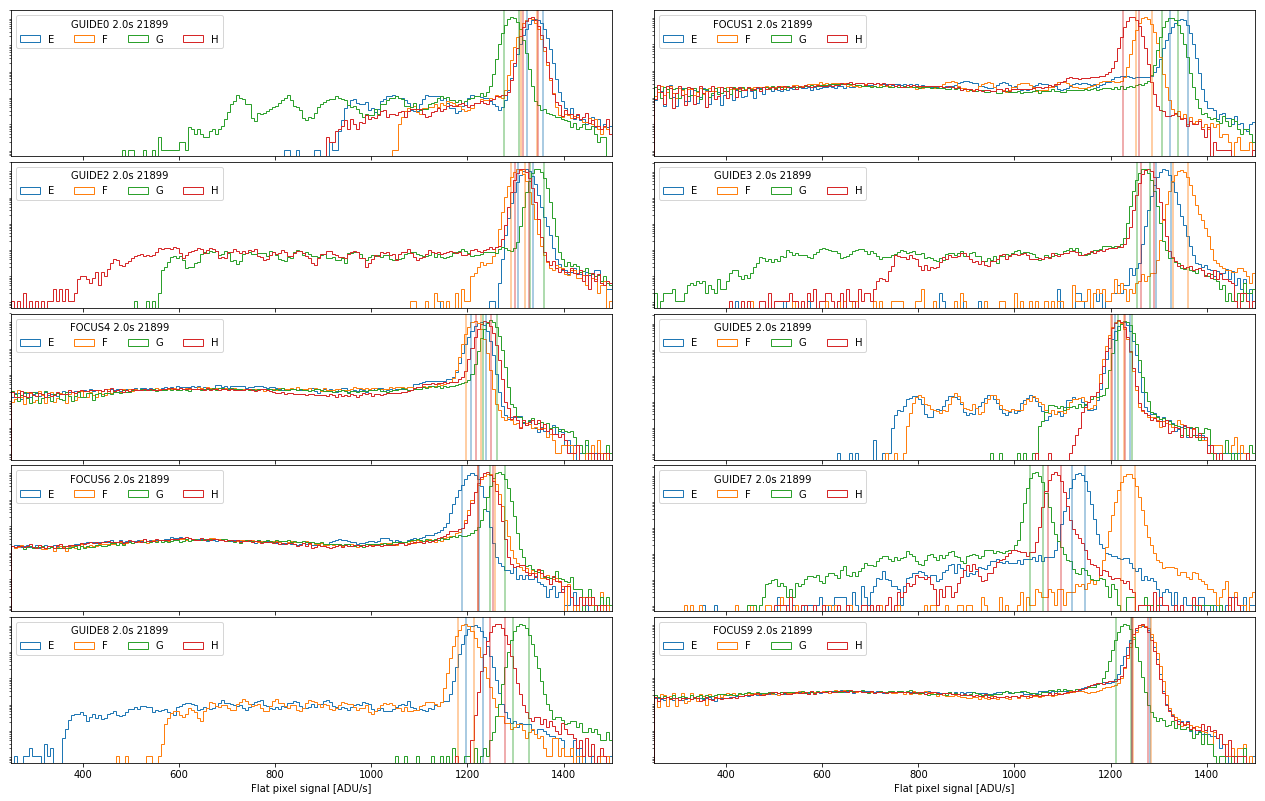

Processing 4 exposures from 20191027 with 4.0s exposure time.
GUIDE0 rescale factors: [0.9992629  0.99954635 1.0005602  1.0004541 ].
FOCUS1 rescale factors: [0.9991655  0.99955064 1.0005527  1.0004498 ].
GUIDE2 rescale factors: [0.9993265  0.99953985 1.0006306  1.0004606 ].
GUIDE3 rescale factors: [1.0000572 0.9998534 1.0004691 0.9999429].
FOCUS4 rescale factors: [0.99941826 0.99959475 1.0006571  1.0004056 ].
GUIDE5 rescale factors: [0.99952716 0.99954826 1.0007299  1.0004522 ].
FOCUS6 rescale factors: [0.9995066 0.9996283 1.0007074 1.0003718].
GUIDE7 rescale factors: [0.9996876 0.999777  1.000608  1.000223 ].


GUIDE8 rescale factors: [0.9993529  0.99955404 1.0006433  1.0004464 ].
FOCUS9 rescale factors: [0.9993499 0.9995574 1.000592  1.000443 ].


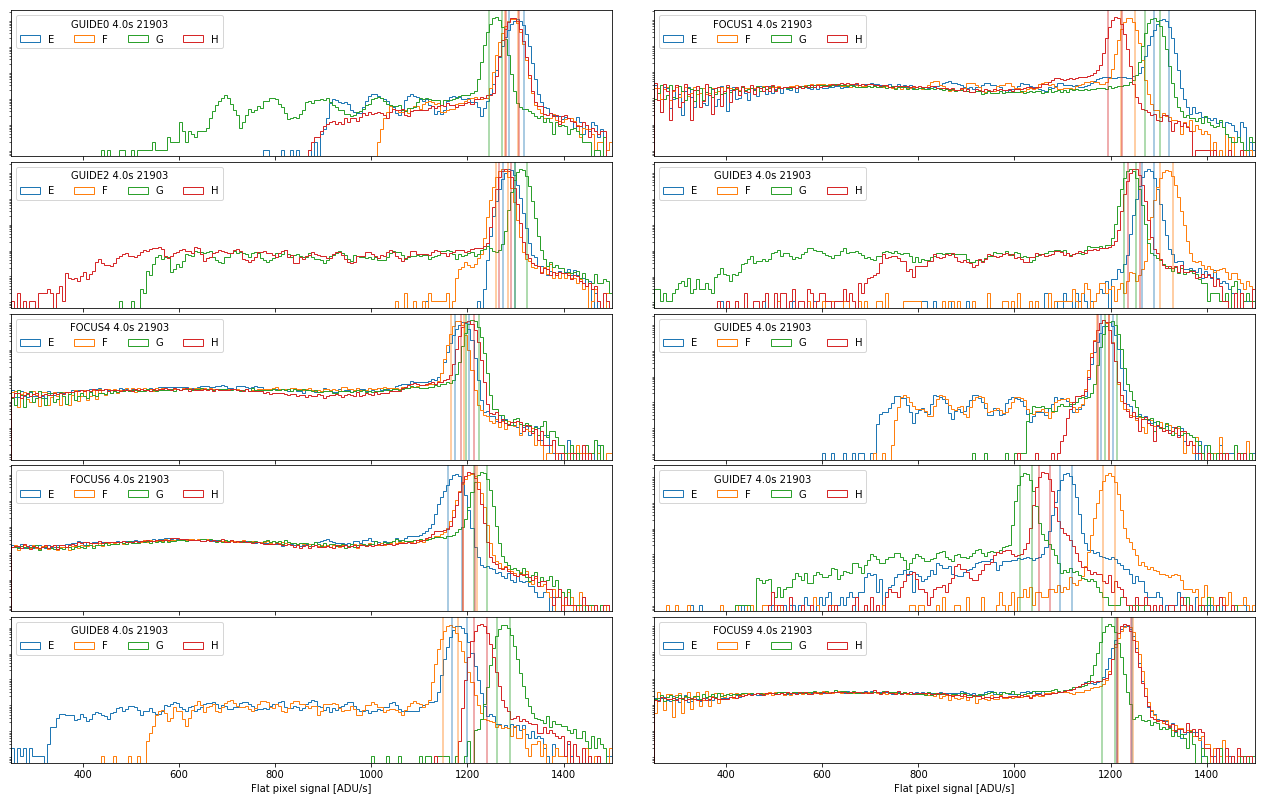

Processing 4 exposures from 20191027 with 6.0s exposure time.
GUIDE0 rescale factors: [0.9993217 1.0002018 0.9997983 1.0005617].
FOCUS1 rescale factors: [0.999386   1.0002068  0.99979335 1.0004734 ].
GUIDE2 rescale factors: [0.99929625 1.0002371  0.999763   1.0005074 ].
GUIDE3 rescale factors: [0.99990404 1.0004399  0.9996831  1.000096  ].
FOCUS4 rescale factors: [0.99932706 1.0002676  0.99980646 1.0001937 ].
GUIDE5 rescale factors: [0.99924046 1.0002606  0.9997395  1.0005175 ].
FOCUS6 rescale factors: [0.999256  1.000275  0.9997251 1.000515 ].
GUIDE7 rescale factors: [0.994558   1.0010135  0.99990916 1.0000908 ].


GUIDE8 rescale factors: [0.99918014 1.0002694  0.9997307  1.0005604 ].
FOCUS9 rescale factors: [0.9992814  1.0002415  0.99975854 1.0005151 ].


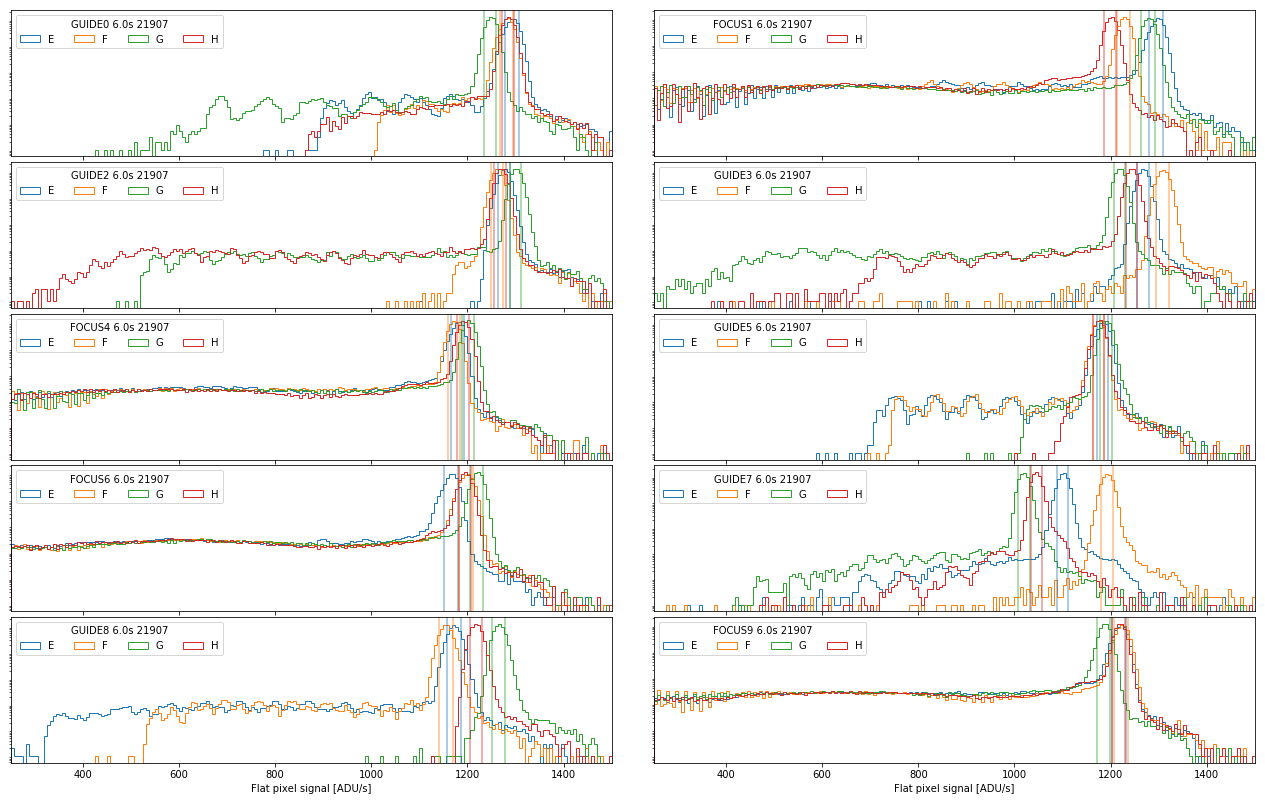

Processing 4 exposures from 20191027 with 8.0s exposure time.
GUIDE0 rescale factors: [1.0000203  0.9999798  0.99972486 1.0003242 ].
FOCUS1 rescale factors: [1.0000066  0.9999934  0.99970067 1.000308  ].
GUIDE2 rescale factors: [1.0000184  0.99998164 0.99972636 1.0003508 ].
GUIDE3 rescale factors: [1.0003425  1.0000416  0.99954385 0.9999584 ].
FOCUS4 rescale factors: [1.0000122 0.9999878 0.9996913 1.000406 ].
GUIDE5 rescale factors: [1.0000148  0.99998516 0.9996993  1.0004042 ].
FOCUS6 rescale factors: [1.0000266 0.9999733 0.9996846 1.0003988].
GUIDE7 rescale factors: [1.0004988  1.0000213  0.99933004 0.99997866].


GUIDE8 rescale factors: [0.99999815 1.0000018  0.99968135 1.0003581 ].
FOCUS9 rescale factors: [1.0000013  0.9999988  0.99969935 1.0003254 ].


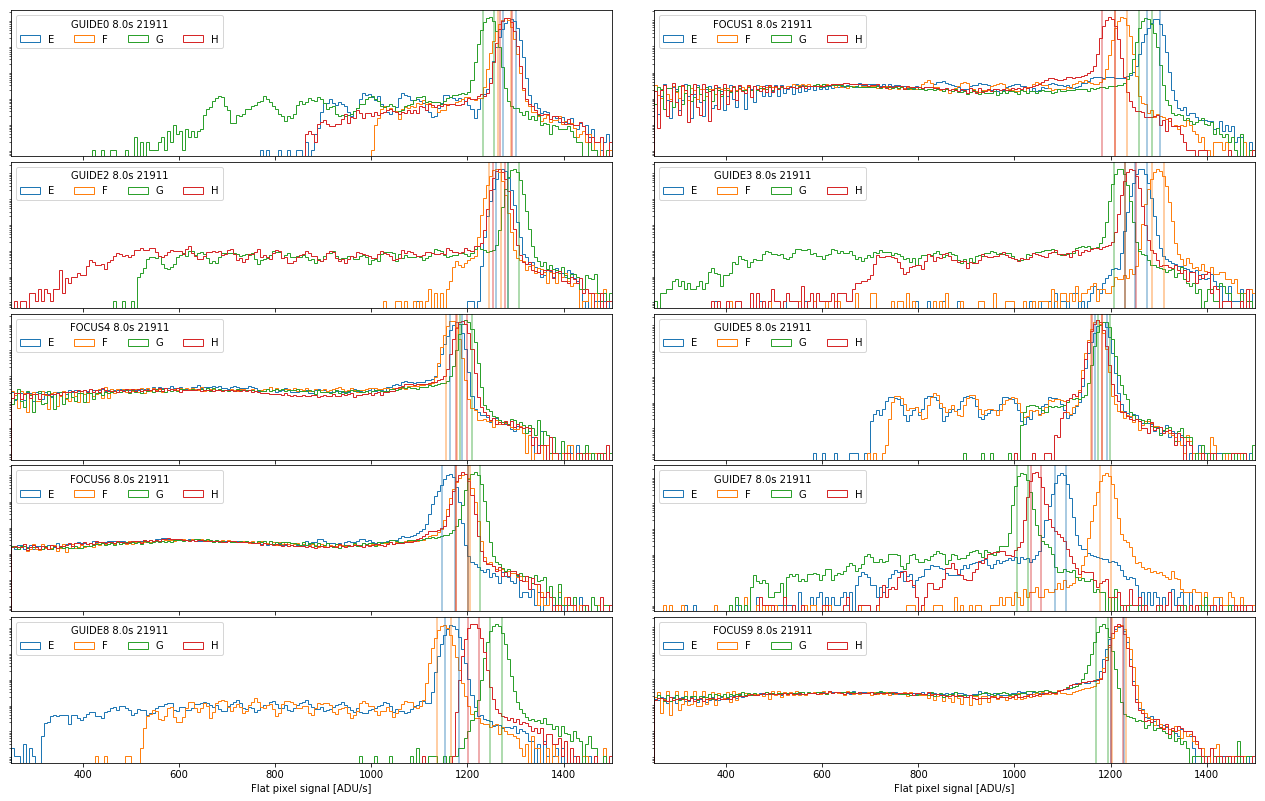

Processing 4 exposures from 20191027 with 10.0s exposure time.
GUIDE0 rescale factors: [0.99995995 0.9995624  1.0000402  1.0003599 ].
FOCUS1 rescale factors: [0.9999916 0.9995043 1.0000085 1.0004084].
GUIDE2 rescale factors: [0.99999624 0.99947226 1.0000038  1.0003657 ].
GUIDE3 rescale factors: [1.0013617  0.99999297 1.000007   0.9999084 ].
FOCUS4 rescale factors: [1.000055   0.9993357  0.99997026 1.0000297 ].
GUIDE5 rescale factors: [1.0000361 0.9993778 0.9999638 1.0003263].
FOCUS6 rescale factors: [1.0000436  0.9993554  0.99995637 1.0003535 ].
GUIDE7 rescale factors: [1.000717  0.9998228 0.9999621 1.0000379].


GUIDE8 rescale factors: [0.99997926 0.99947685 1.0000207  1.0003532 ].
FOCUS9 rescale factors: [0.99992406 0.99951327 1.0000759  1.0003773 ].


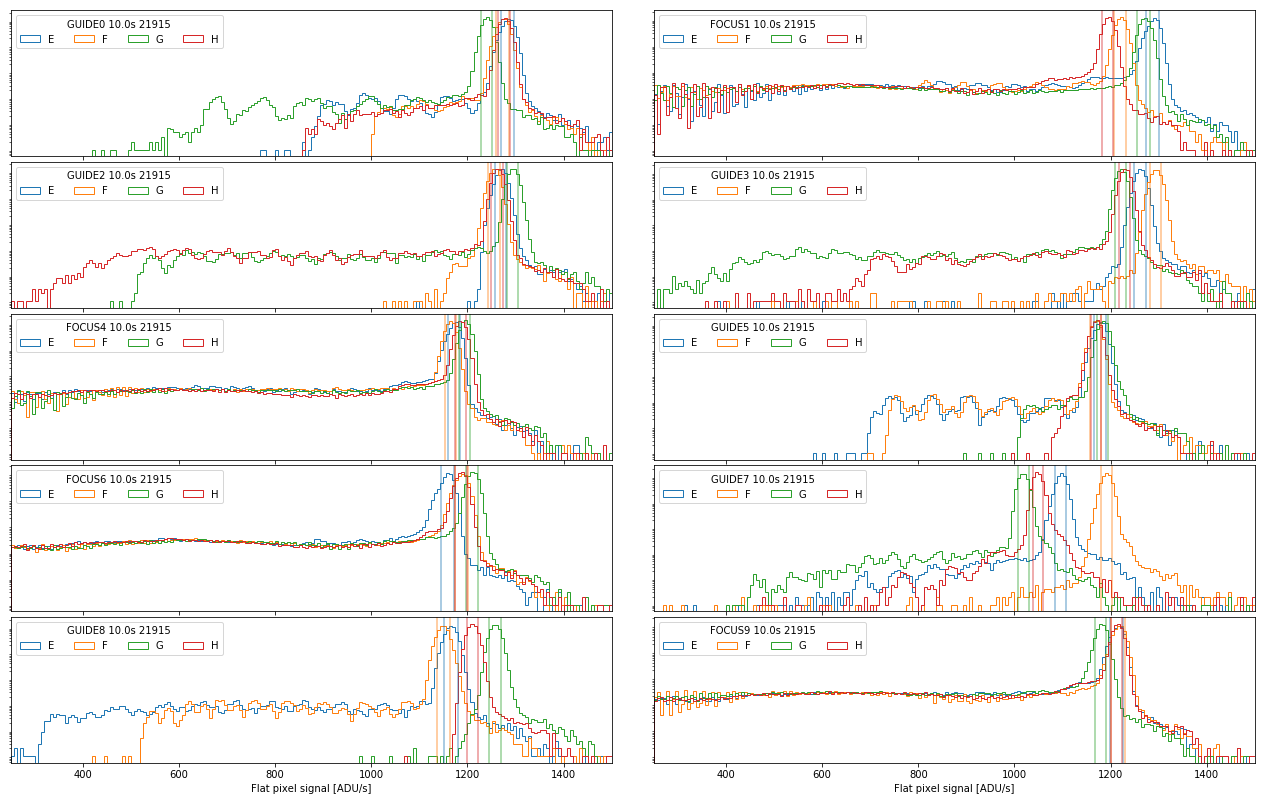

Processing 4 exposures from 20191027 with 12.0s exposure time.
GUIDE0 rescale factors: [1.0000747 1.0002017 0.9999253 0.9995338].
FOCUS1 rescale factors: [1.0000992  1.0002387  0.9999008  0.99955523].
GUIDE2 rescale factors: [1.0000863  1.0002087  0.99991375 0.9995026 ].
GUIDE3 rescale factors: [1.000775   1.0003637  0.99963653 0.9988185 ].
FOCUS4 rescale factors: [1.0000991  1.0001905  0.99990094 0.99953645].
GUIDE5 rescale factors: [1.0001018 1.0001767 0.9998982 0.9994804].
FOCUS6 rescale factors: [1.0001149  1.0001798  0.99988526 0.99947965].
GUIDE7 rescale factors: [1.0002507  1.0003586  0.9997494  0.99900043].


GUIDE8 rescale factors: [1.0001329  1.0001438  0.9998671  0.99947655].
FOCUS9 rescale factors: [1.0000895 1.0002162 0.9999104 0.999516 ].


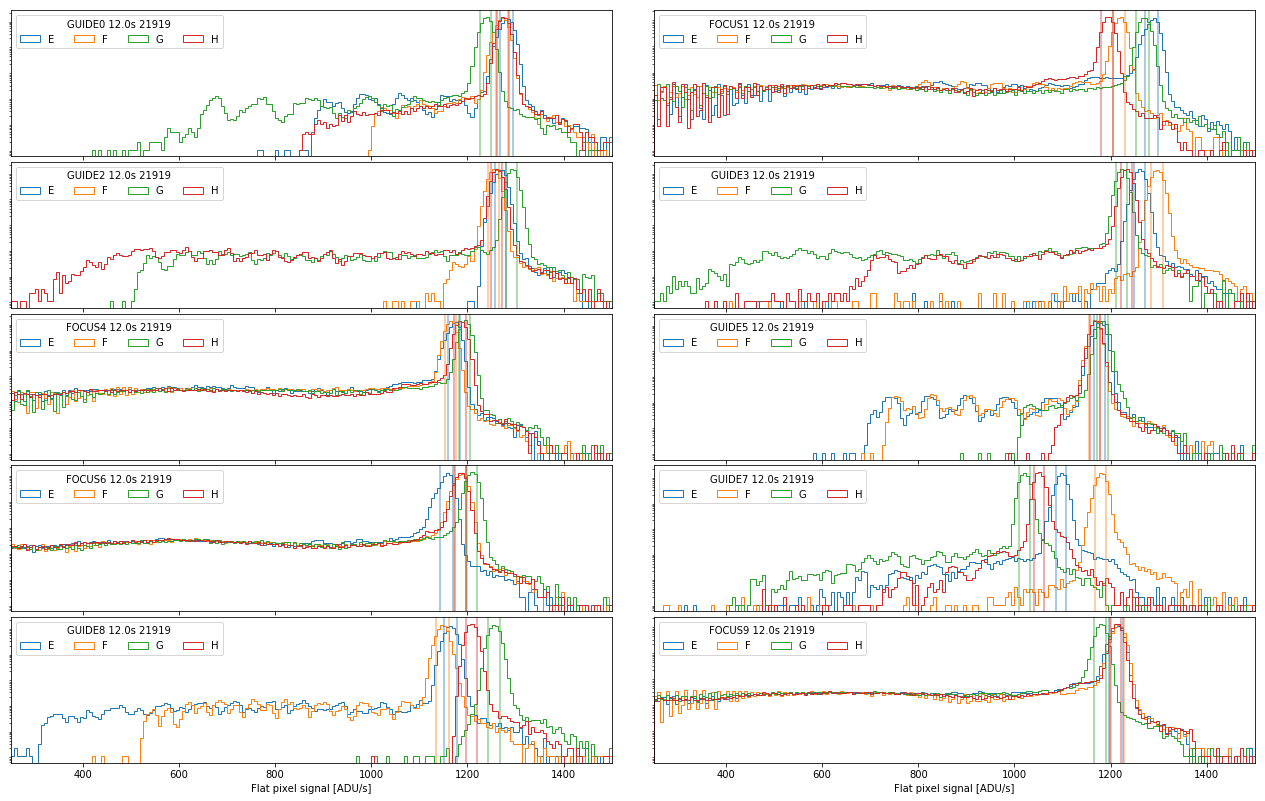

Processing 4 exposures from 20191027 with 14.0s exposure time.
GUIDE0 rescale factors: [1.000222   0.9998392  0.99984103 1.000159  ].
FOCUS1 rescale factors: [1.0002056  0.9998508  0.99979675 1.0001493 ].
GUIDE2 rescale factors: [1.0002263 0.999866  0.9998305 1.0001341].
GUIDE3 rescale factors: [1.0010086  1.0002286  0.99969393 0.99977154].
FOCUS4 rescale factors: [1.0002904  0.99987864 0.9997039  1.0001212 ].
GUIDE5 rescale factors: [1.000328   0.99991107 0.99971974 1.0000889 ].
FOCUS6 rescale factors: [1.0003171  0.9999325  0.99969447 1.0000674 ].
GUIDE7 rescale factors: [1.0008513 1.000172  0.99977   0.999828 ].


GUIDE8 rescale factors: [1.0002269  0.9998684  0.99986124 1.0001316 ].
FOCUS9 rescale factors: [1.0002526  0.99986416 0.99983937 1.0001358 ].


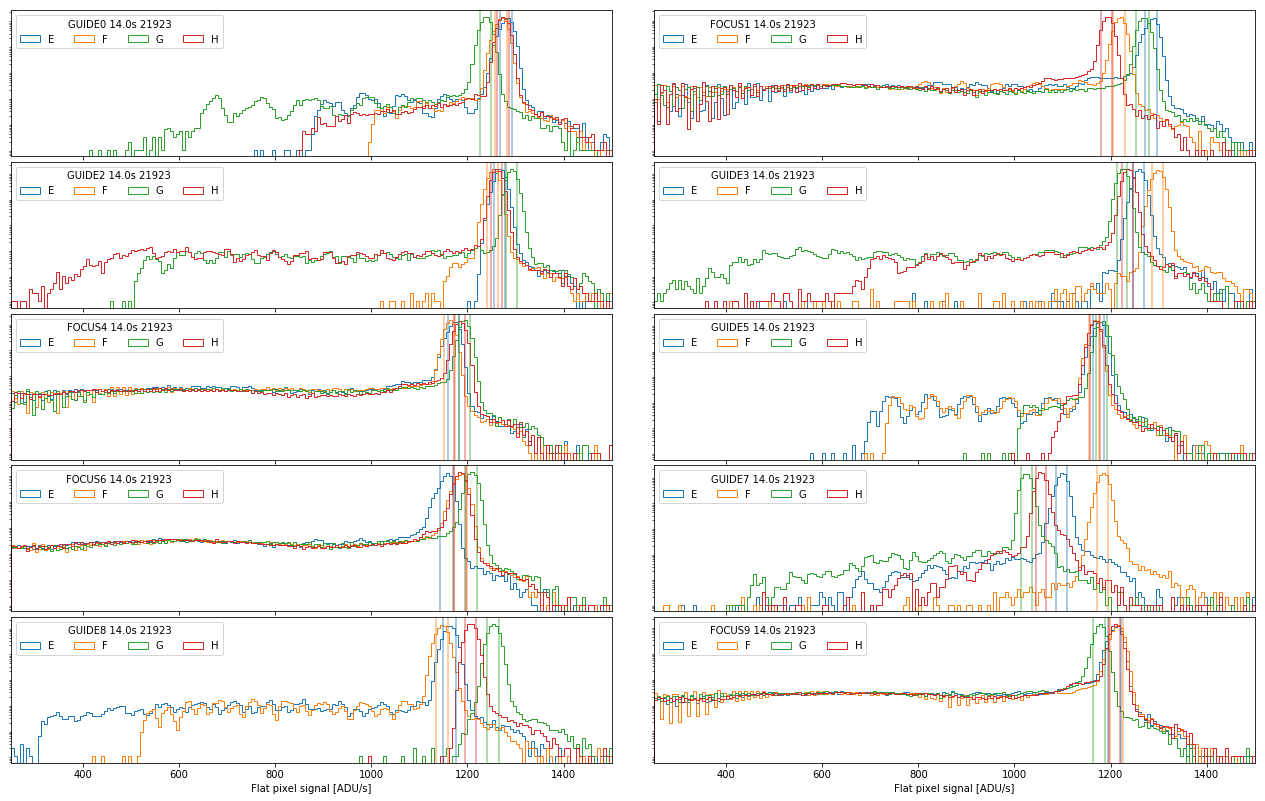

Processing 4 exposures from 20191027 with 16.0s exposure time.
GUIDE0 rescale factors: [0.9999762 1.000496  1.0000237 0.9998713].
FOCUS1 rescale factors: [0.99995226 1.0005083  1.0000477  0.99984896].
GUIDE2 rescale factors: [0.9999757  1.0004728  1.0000242  0.99986047].
GUIDE3 rescale factors: [1.0002638  1.0004611  0.99973637 0.99930006].
FOCUS4 rescale factors: [0.9999597 1.0005184 1.0000402 0.9998579].
GUIDE5 rescale factors: [1.000418   1.0009677  0.99958235 0.9993924 ].
FOCUS6 rescale factors: [0.99995387 1.0004811  1.0000463  0.9998058 ].
GUIDE7 rescale factors: [0.9955954 1.00122   1.000316  0.9996841].


GUIDE8 rescale factors: [0.99997437 1.000502   1.0000257  0.99987674].
FOCUS9 rescale factors: [0.9999698 1.0005032 1.0000302 0.9998683].


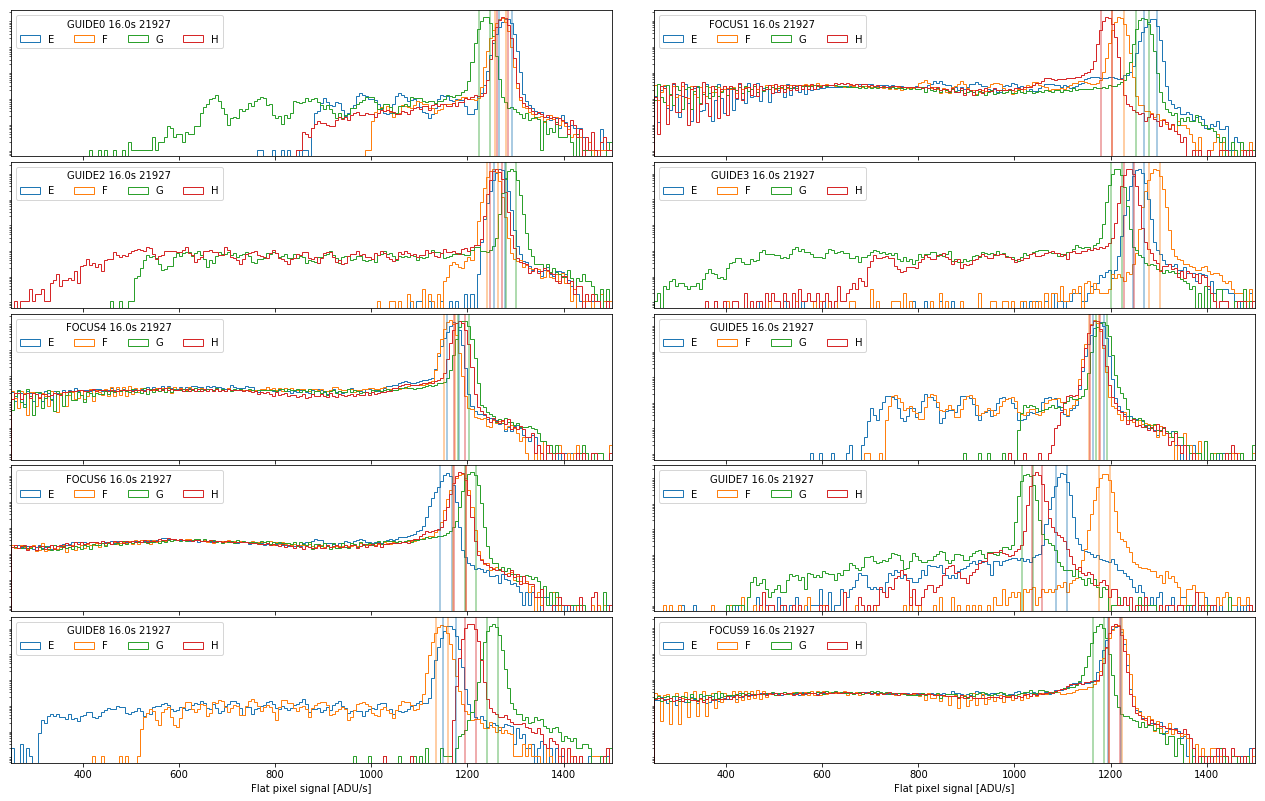

Processing 4 exposures from 20191027 with 18.0s exposure time.
GUIDE0 rescale factors: [0.9996767  0.99989027 1.0001099  1.000156  ].
FOCUS1 rescale factors: [0.99966425 0.9998844  1.0001156  1.0001633 ].
GUIDE2 rescale factors: [0.9996594  0.99989897 1.0001011  1.00017   ].


GUIDE3 rescale factors: [0.9943831  1.000743   1.0002477  0.99975246].
FOCUS4 rescale factors: [0.99969274 0.9998903  1.0001096  1.0002105 ].
GUIDE5 rescale factors: [0.99969864 0.99988073 1.0001192  1.0002308 ].
FOCUS6 rescale factors: [0.99974054 0.9998872  1.0001129  1.0002797 ].
GUIDE7 rescale factors: [1.000212   1.00004    0.9998205  0.99996006].


GUIDE8 rescale factors: [0.999654   0.99987364 1.0001264  1.000217  ].
FOCUS9 rescale factors: [0.9996594 0.9998883 1.0001117 1.0001872].


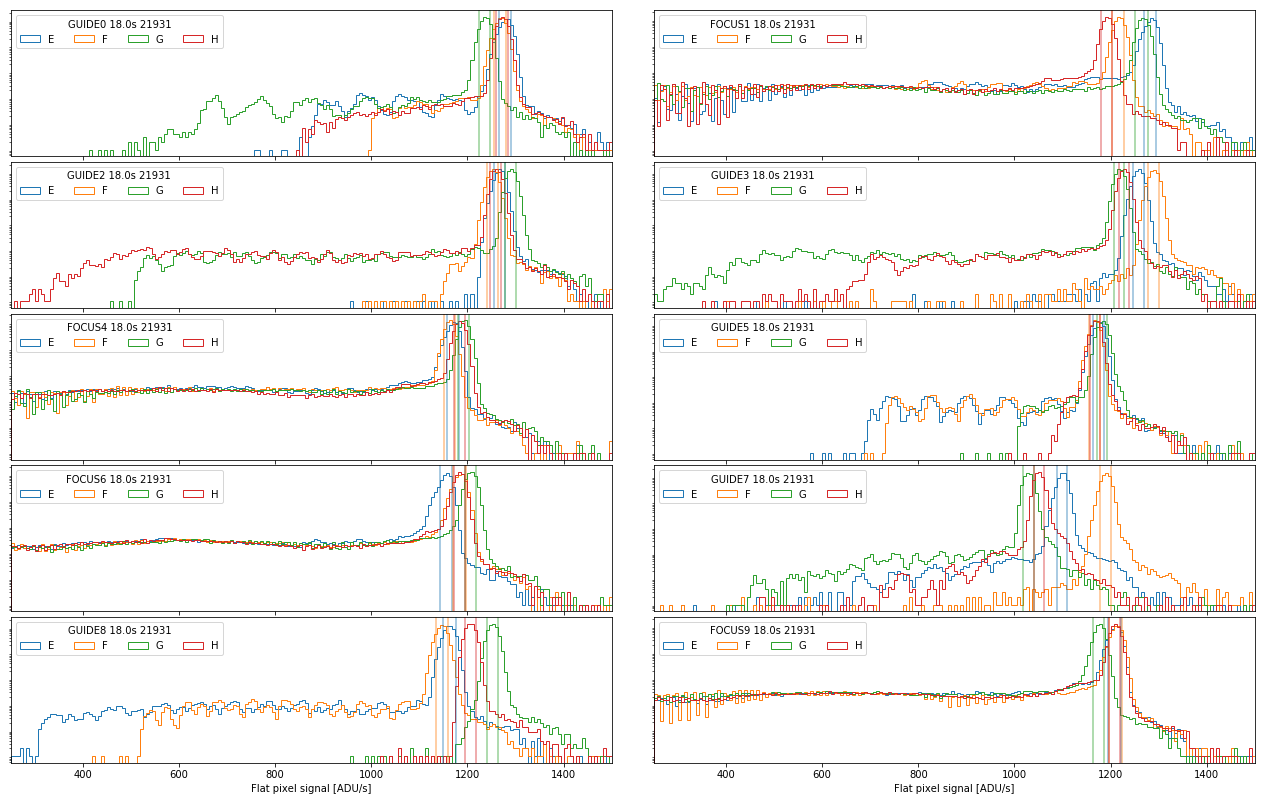

Processing 4 exposures from 20191027 with 20.0s exposure time.
GUIDE0 rescale factors: [0.9999788 1.0000212 1.0004206 0.9999012].
FOCUS1 rescale factors: [0.9999715  1.0000284  1.0004557  0.99988866].
GUIDE2 rescale factors: [0.99999505 1.0000049  1.000441   0.99987805].
GUIDE3 rescale factors: [1.0006174  1.0000596  0.99994045 0.998805  ].
FOCUS4 rescale factors: [0.9999954  1.0000045  1.0004209  0.99952424].
GUIDE5 rescale factors: [0.99999386 1.0000062  1.0004253  0.9997816 ].
FOCUS6 rescale factors: [0.99998724 1.0000126  1.0004048  0.99977195].


GUIDE7 rescale factors: [1.0001819 0.9998182 1.000203  0.9992555].


GUIDE8 rescale factors: [0.9999799  1.0000201  1.000445   0.99989563].
FOCUS9 rescale factors: [0.9999649 1.000035  1.0004106 0.9998797].


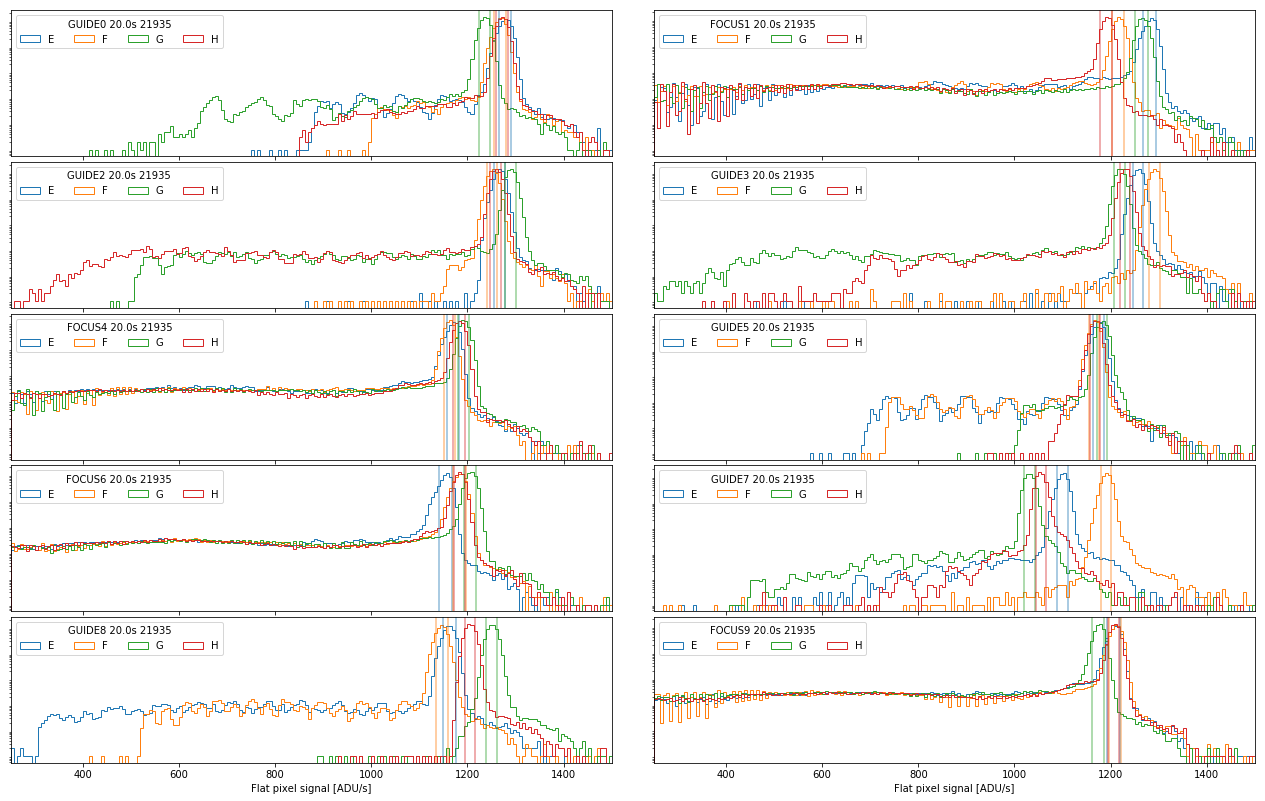

Processing 4 exposures from 20191027 with 22.0s exposure time.
GUIDE0 rescale factors: [1.0000095  0.99999046 1.0002015  0.99984777].
FOCUS1 rescale factors: [1.0000191  0.99998105 1.0001719  0.9997965 ].
GUIDE2 rescale factors: [1.0000159 0.9999841 1.0001838 0.9997992].
GUIDE3 rescale factors: [1.000599   1.0000771  0.9999228  0.99915576].
FOCUS4 rescale factors: [1.000422  1.0002964 0.9997039 0.9993122].


GUIDE5 rescale factors: [1.0000696  0.99993044 1.0001551  0.9997699 ].
FOCUS6 rescale factors: [1.0000805  0.99991953 1.000158   0.9997875 ].


GUIDE7 rescale factors: [1.000198   1.0000584  0.99994165 0.9994501 ].


GUIDE8 rescale factors: [1.0000331  0.99996686 1.0002685  0.9998503 ].
FOCUS9 rescale factors: [1.0000172 0.9999828 1.0002099 0.9998259].


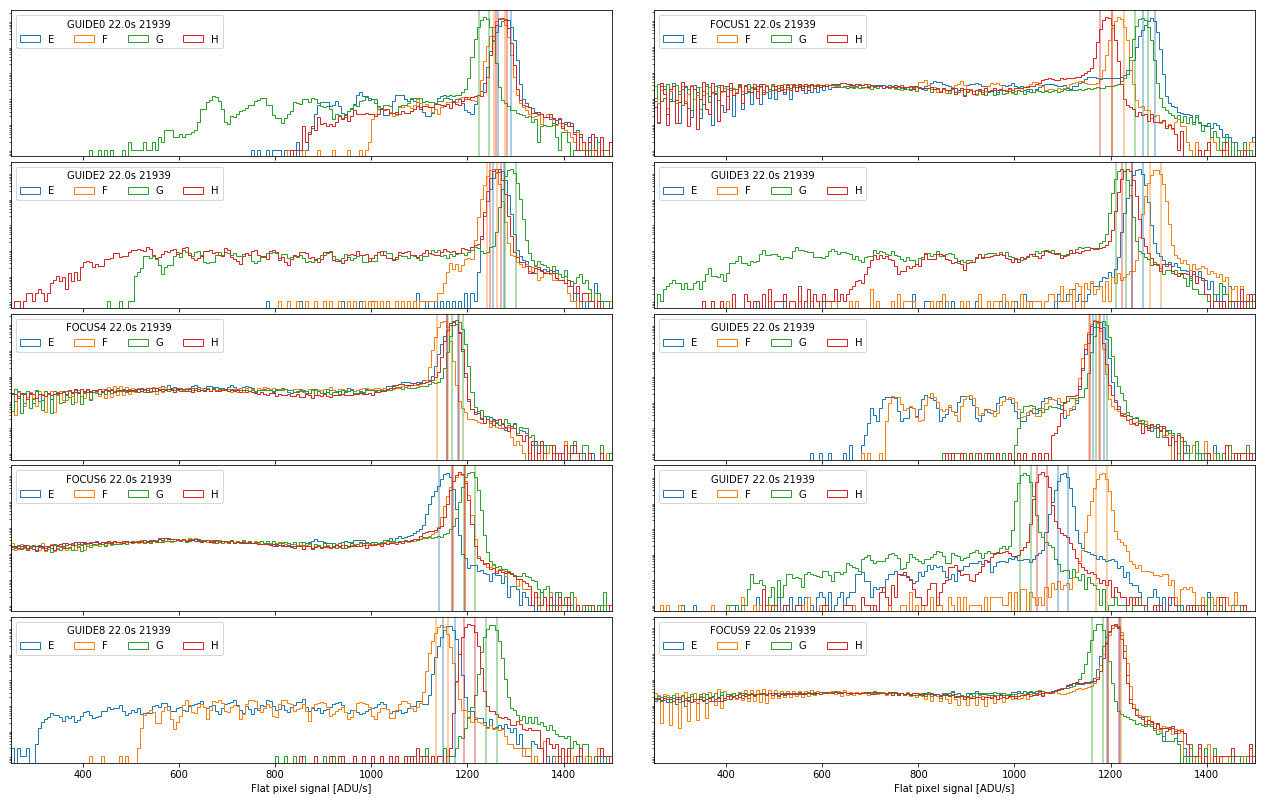

Processing 4 exposures from 20191027 with 24.0s exposure time.
GUIDE0 rescale factors: [1.0000731 0.9992704 1.0000588 0.9999412].
FOCUS1 rescale factors: [1.0000678  0.9992472  1.0000699  0.99993217].
GUIDE2 rescale factors: [1.000069  0.9992071 1.0000734 0.999931 ].


GUIDE3 rescale factors: [1.0008029 0.9996013 1.0001982 0.9998018].
FOCUS4 rescale factors: [1.0007058  0.99912494 1.0000458  0.99995416].
GUIDE5 rescale factors: [1.0000641  0.99912506 1.0000468  0.99995303].
FOCUS6 rescale factors: [1.000041   0.99912363 1.0000364  0.99996364].


GUIDE7 rescale factors: [1.0005617 0.9992894 1.000178  0.9998221].


GUIDE8 rescale factors: [1.0000603  0.99916697 1.0000442  0.99995583].
FOCUS9 rescale factors: [1.0000703  0.9992509  1.0000521  0.99994797].


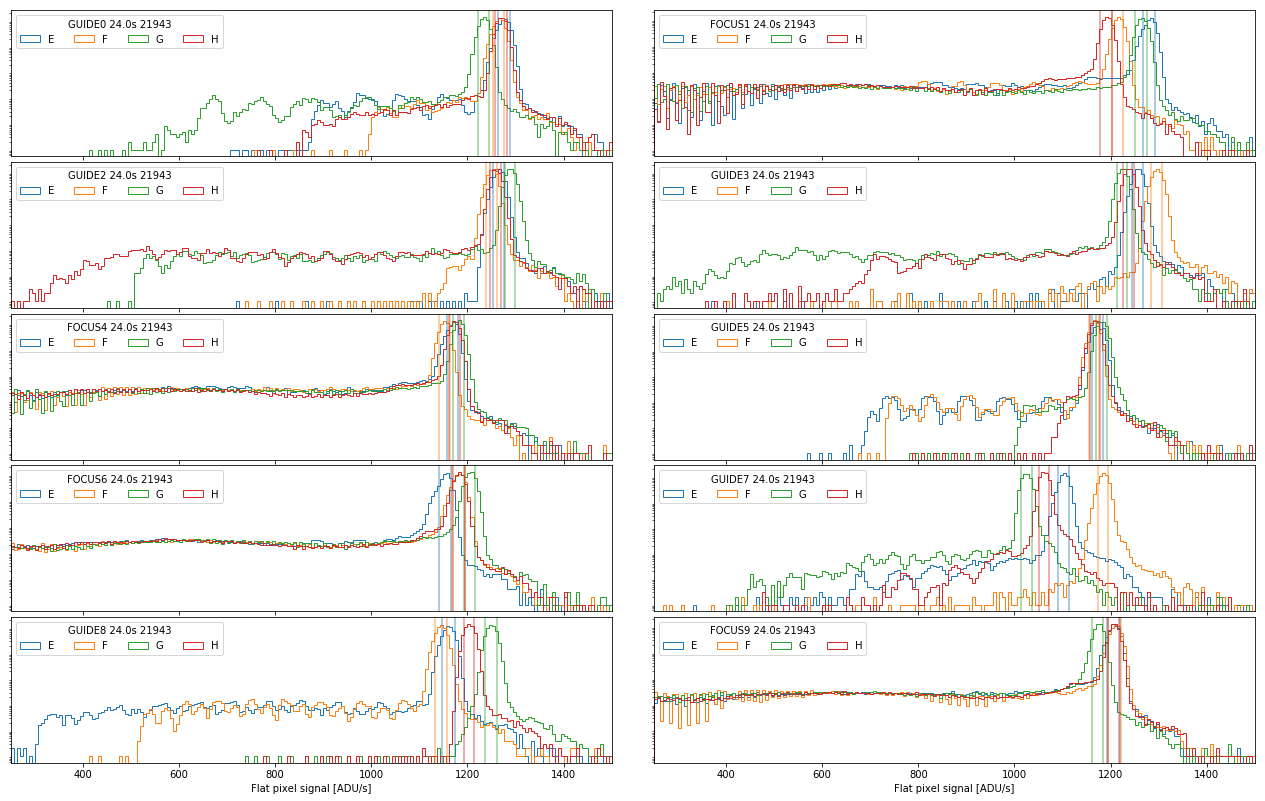

Processing 4 exposures from 20191027 with 26.0s exposure time.
GUIDE0 rescale factors: [0.9998358  1.0003363  0.99971676 1.0001644 ].
FOCUS1 rescale factors: [0.99987566 1.0003172  0.99971884 1.0001243 ].
GUIDE2 rescale factors: [0.9998523  1.0003501  0.99968356 1.0001478 ].


GUIDE3 rescale factors: [0.9970871 0.9972933 1.0028404 1.0027214].
FOCUS4 rescale factors: [0.9998504  1.0002868  0.99952966 1.0001496 ].


GUIDE5 rescale factors: [0.9998583 1.0002887 0.9994907 1.0001417].
FOCUS6 rescale factors: [0.99986726 1.000239   0.9994433  1.0001328 ].


GUIDE7 rescale factors: [1.000106   1.0002679  0.99954087 0.9998941 ].


GUIDE8 rescale factors: [0.9998317  1.0003427  0.99969846 1.0001684 ].
FOCUS9 rescale factors: [0.999839  1.0003417 0.9997208 1.0001612].


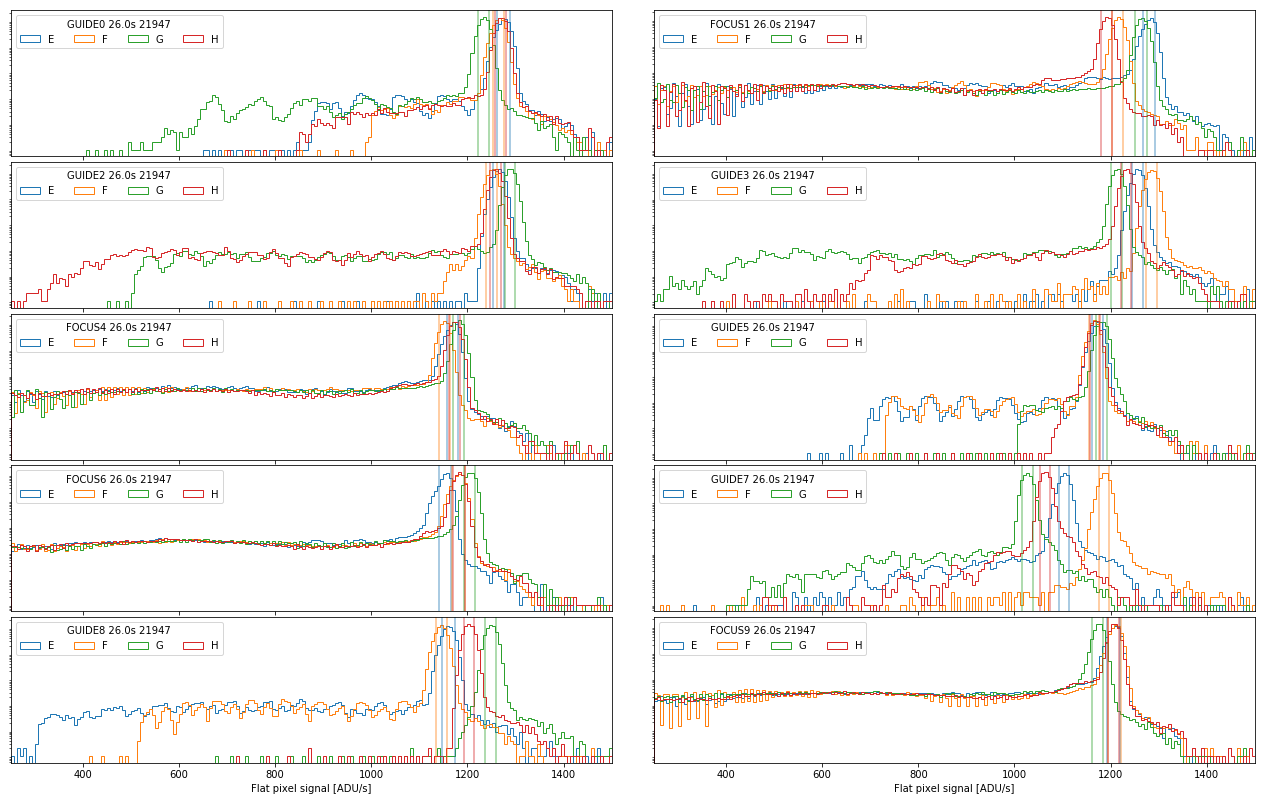

Processing 4 exposures from 20191027 with 28.0s exposure time.
GUIDE0 rescale factors: [0.9999288 1.0001854 0.9997625 1.0000712].
FOCUS1 rescale factors: [0.99994147 1.0001878  0.99976754 1.0000585 ].
GUIDE2 rescale factors: [0.9999294 1.0002075 0.9997592 1.0000707].


GUIDE3 rescale factors: [1.0007846  1.000473   0.9995274  0.99937934].
FOCUS4 rescale factors: [1.0001862 1.0004766 0.9994702 0.9998138].


GUIDE5 rescale factors: [0.99988896 1.0001732  0.9997636  1.0001111 ].
FOCUS6 rescale factors: [0.999908  1.0001662 0.9997473 1.0000921].


GUIDE7 rescale factors: [0.99509495 1.0010874  1.0001199  0.9998801 ].


GUIDE8 rescale factors: [0.99992174 1.0001972  0.9997345  1.0000783 ].
FOCUS9 rescale factors: [0.99992245 1.000184   0.99974394 1.0000776 ].


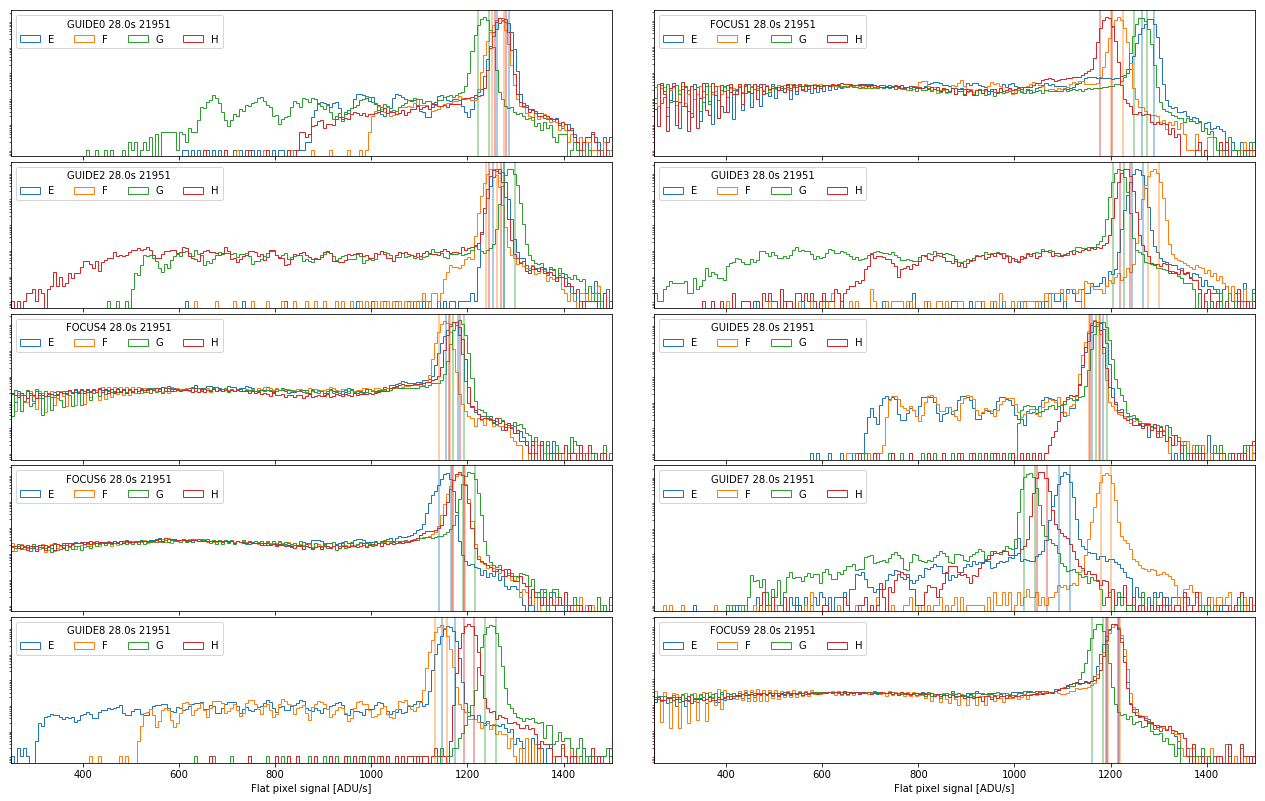

Processing 4 exposures from 20191027 with 30.0s exposure time.
GUIDE0 rescale factors: [1.0004085  0.9999839  1.0000162  0.99996394].
FOCUS1 rescale factors: [1.0004295  0.99998975 1.0000103  0.99995613].
GUIDE2 rescale factors: [1.0004334  0.9999934  1.0000067  0.99993676].
GUIDE3 rescale factors: [1.0010849  1.0002176  0.99978256 0.99931484].
FOCUS4 rescale factors: [1.0004627  1.0000194  0.9999805  0.99986655].


GUIDE5 rescale factors: [1.0004667  1.000008   0.99999213 0.9998222 ].
FOCUS6 rescale factors: [1.000503   1.0000027  0.99999714 0.99983364].


GUIDE7 rescale factors: [1.0012157 1.0002315 0.9997686 0.9992422].


GUIDE8 rescale factors: [1.0004432  0.9999674  1.0000325  0.99992275].
FOCUS9 rescale factors: [1.0004079  0.99997884 1.0000212  0.9999531 ].


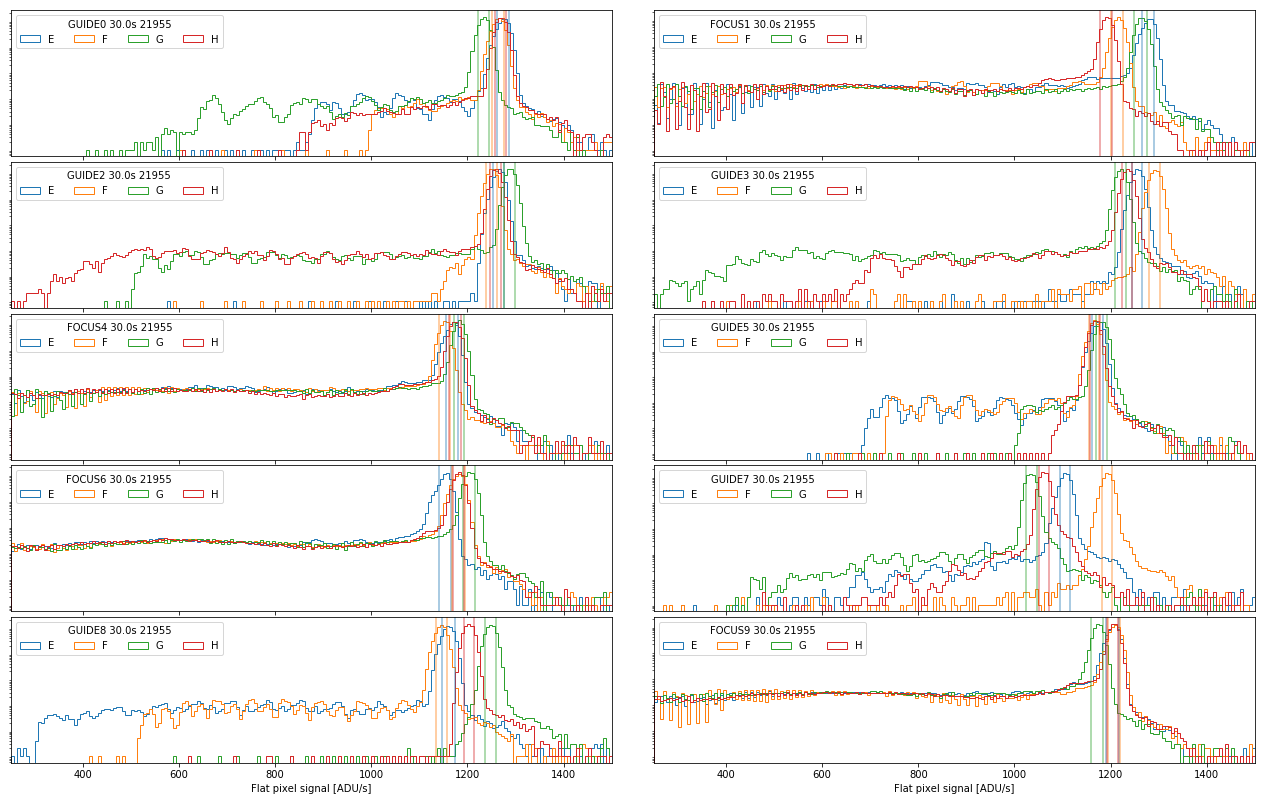

Processing 4 exposures from 20191027 with 32.0s exposure time.
GUIDE0 rescale factors: [1.000171  0.9999974 1.0000025 0.9999871].
FOCUS1 rescale factors: [1.0001633 0.9999991 1.0000008 0.9999762].
GUIDE2 rescale factors: [1.0001746 0.9999946 1.0000054 0.9999398].


GUIDE3 rescale factors: [1.0006907  1.0001727  0.99982727 0.99939966].
FOCUS4 rescale factors: [1.000224  1.0000235 0.9999764 0.9992402].


GUIDE5 rescale factors: [1.0002522  1.0000299  0.9999701  0.99978334].
FOCUS6 rescale factors: [1.0002763  1.0000393  0.99996066 0.999773  ].


GUIDE7 rescale factors: [1.00086    1.0002265  0.9997736  0.99930173].


GUIDE8 rescale factors: [1.0002192  1.0000074  0.99999255 0.9999513 ].
FOCUS9 rescale factors: [1.0001698  1.000011   0.99998903 0.999974  ].


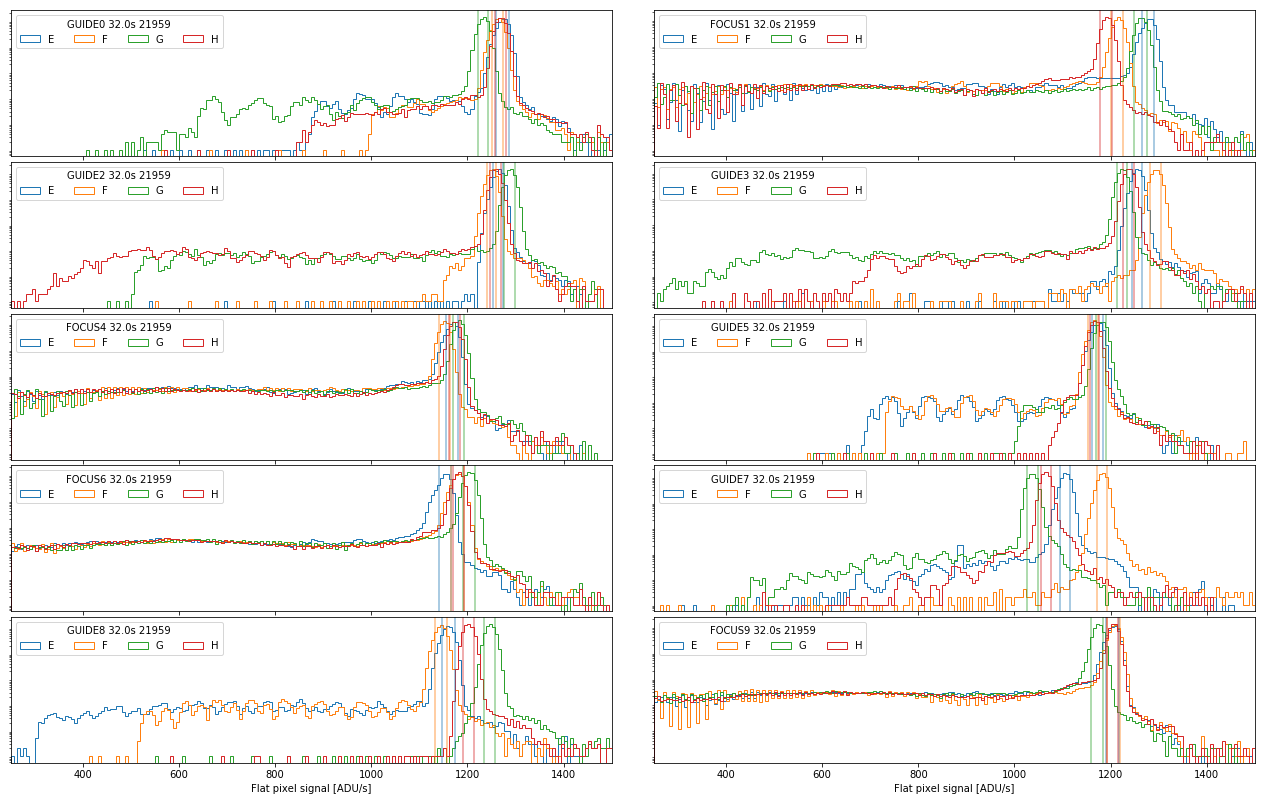

In [16]:
for i in range(16):
    first = 21899 + 4 * i
    texp = 2 * (i + 1)
    process_flats(20191027, first, first + 3, save=str(plotdir / 'flatpix_20191027_{0}.png'.format(texp)))
    plt.show()

## Estimate variance at each exposure time

In [17]:
def estimate_variance(first, maxdiff=1000, nbins=200, nsig=4.5, save=None):
    flat = flats[first]
    bins = np.linspace(-maxdiff, +maxdiff, nbins + 1)
    fig, axes = plt.subplots(5, 2, sharex=True, figsize=(18, 11))
    varstats = {}
    for k, gfa in enumerate(desietcimg.gfa.GFACamera.gfa_names):
        varstats[gfa] = {}
        ax = axes[k // 2, k % 2]
        for j, amp in enumerate(desietcimg.gfa.GFACamera.amp_names):
            pixmedian = flat['pixmedian'][gfa][amp]
            amplo, ampmed, amphi = flat['pixstats'][gfa][amp]
            pixdiff = flat['pixdiff'][gfa][amp]
            # Select pixels whose median is within [amplo, amphi]
            sel = (amplo < pixmedian) & (pixmedian < amphi)
            # Histogram diffs between each pair of exposure for selected pixels.
            c = plt.rcParams['axes.prop_cycle'].by_key()['color'][j]
            for i in range(flat['nexp'] - 1):
                ax.hist(pixdiff[i, sel].reshape(-1), bins=bins, color=c,
                        histtype='step', label=amp if i == 0 else None)
            # Perform sigma clipping on all diffs combined.
            clipped, lo, hi = scipy.stats.sigmaclip(pixdiff[:, sel].reshape(-1), low=nsig, high=nsig)
            for x in (lo, hi):
                ax.axvline(x, ls='-', c=c, alpha=0.5)
            # Calculate and save the clipped variance in ADU ** 2.
            varstats[gfa][amp] = (np.var(clipped), lo, hi)
        if k in (8, 9):
            ax.set_xlabel('Flat Residual [ADU]')
            ax.set_xlim(bins[0], bins[-1])
        ax.set_yscale('log')
        ax.set_yticks([])
        ax.legend(ncol=4, title='{0} {1}s {2}'.format(gfa, flat['texp'], first))
    plt.subplots_adjust(left=0.03, right=0.99, bottom=0.04, top=0.99, wspace=0.07, hspace=0.04)
    if save:
        plt.savefig(save)
    if 'varstats' in flat:
        print('Replacing previous results')
    flat['varstats'] = varstats

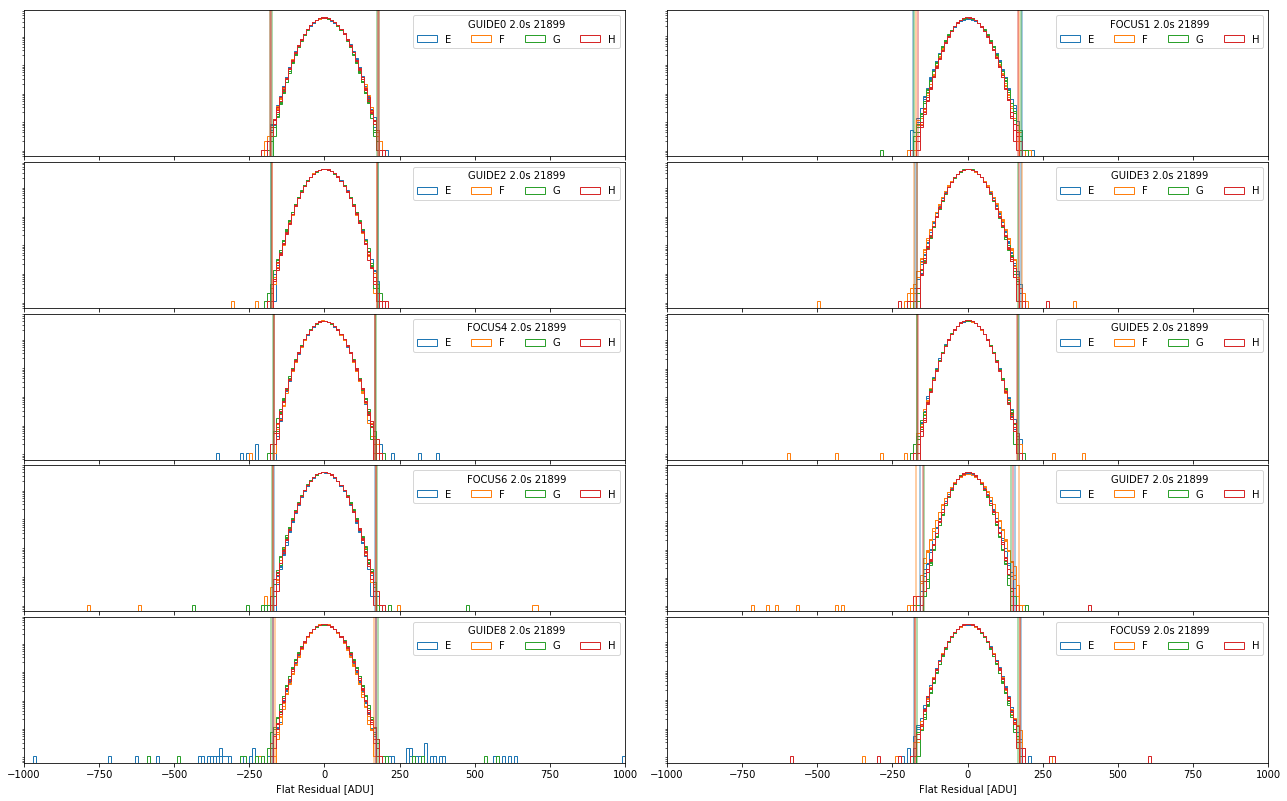

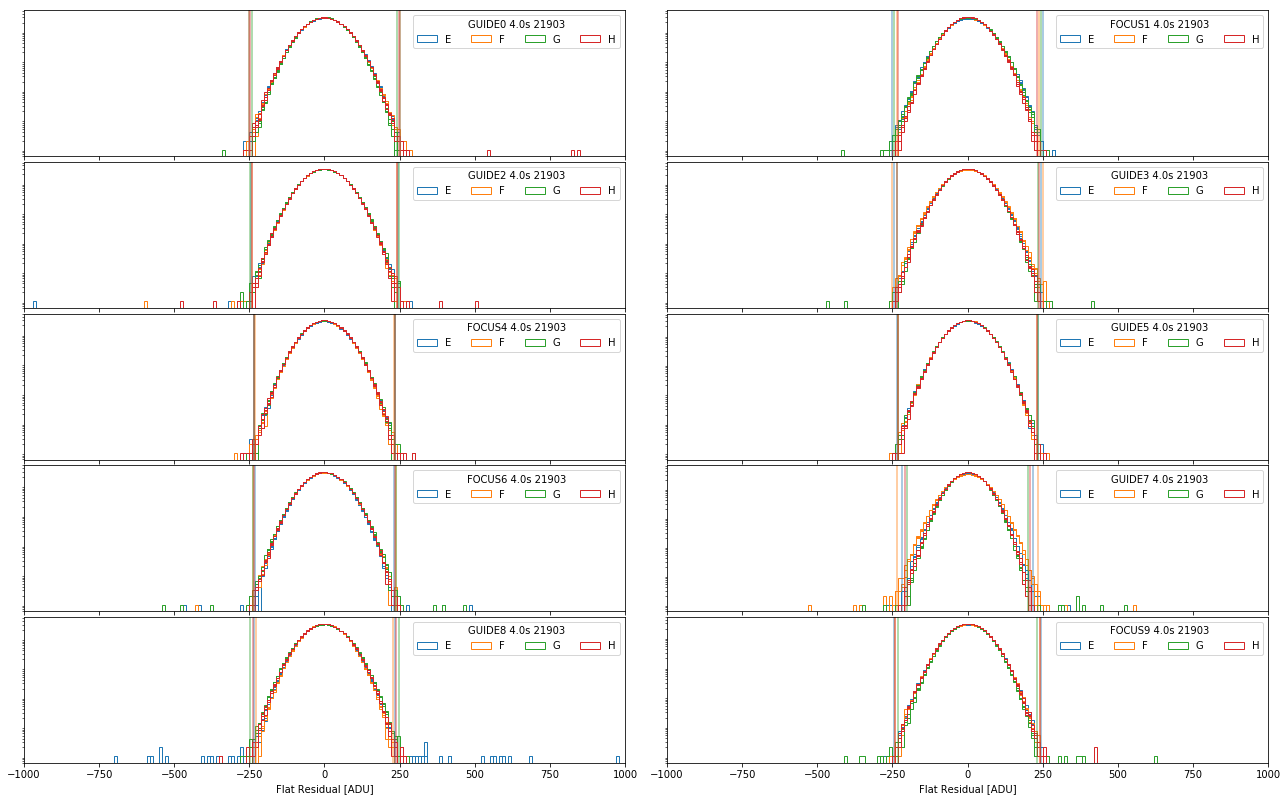

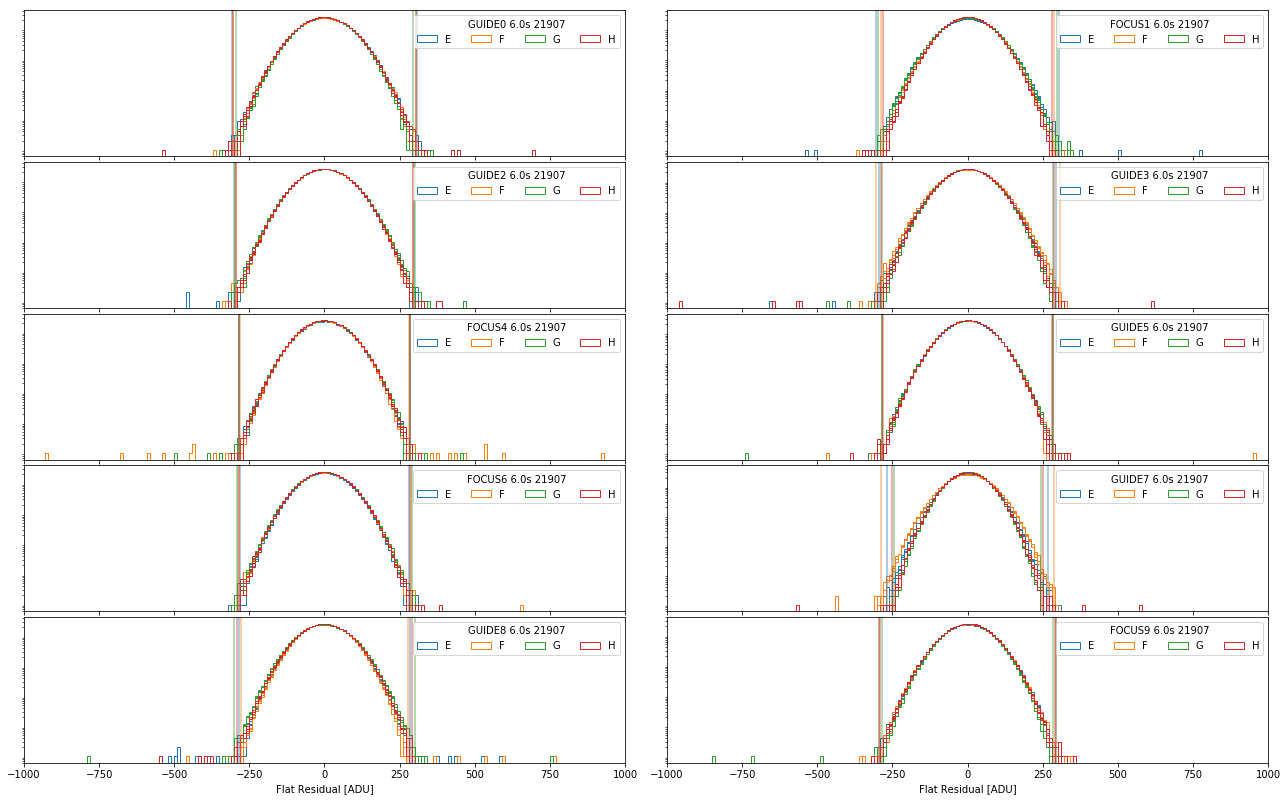

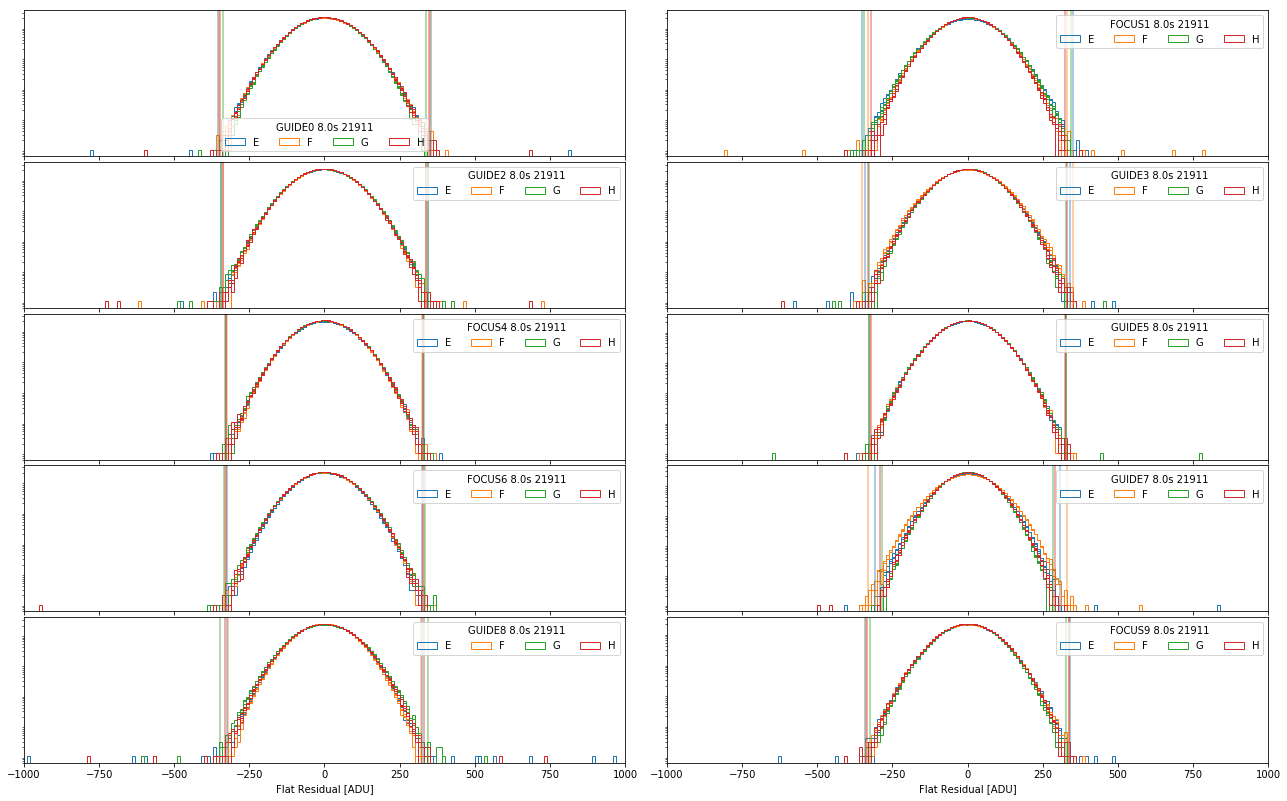

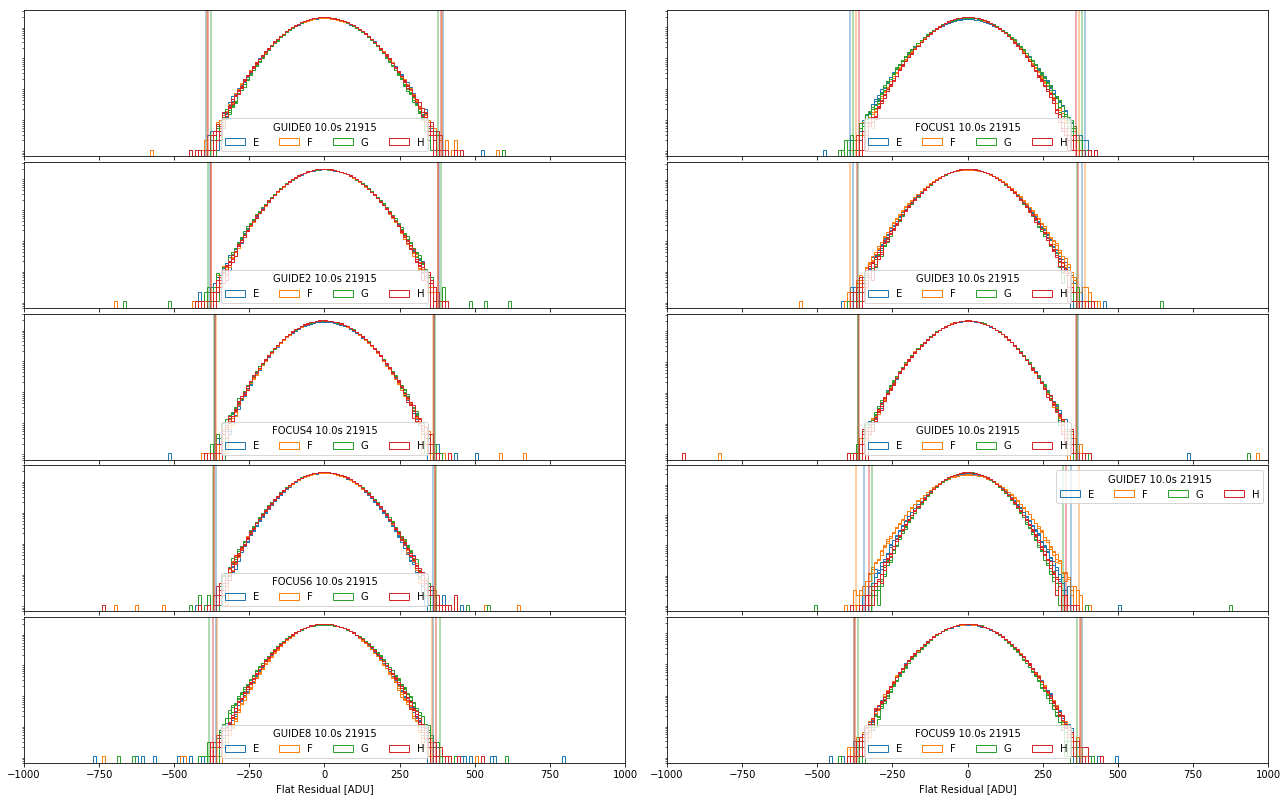

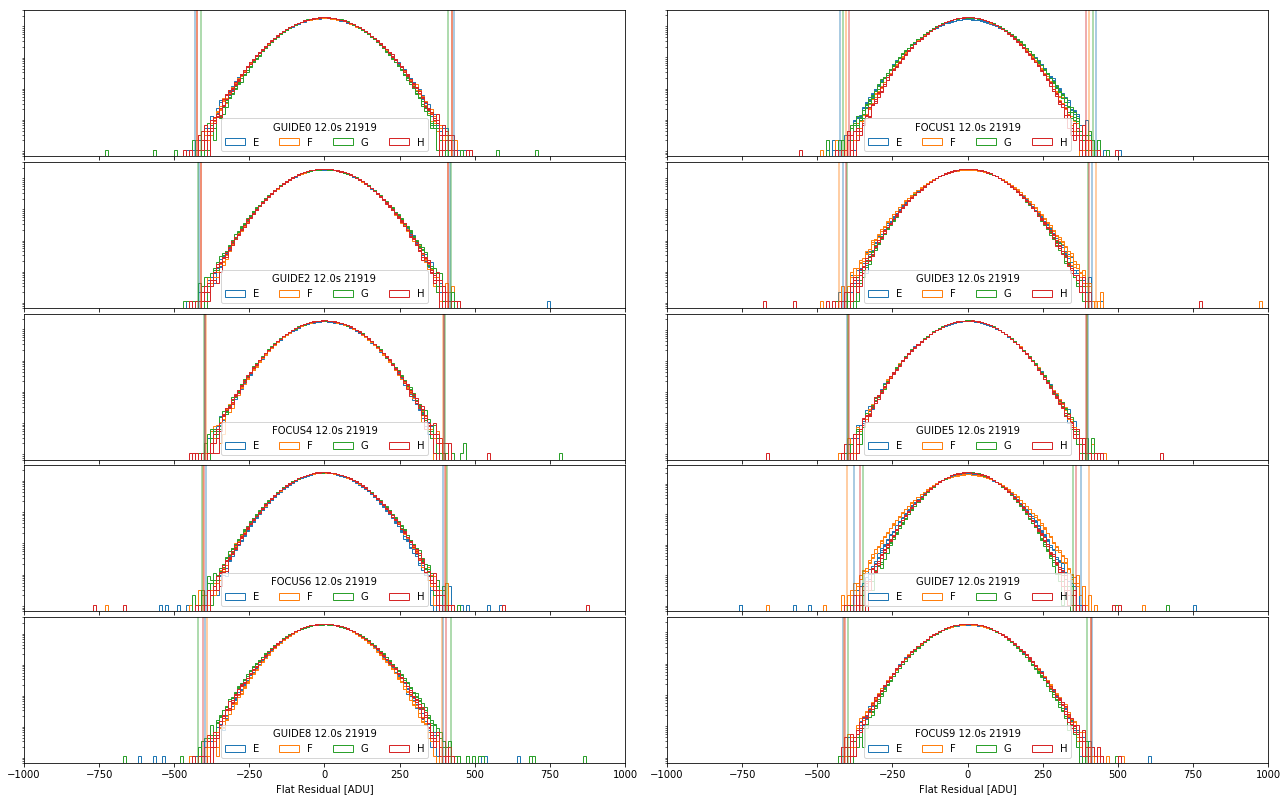

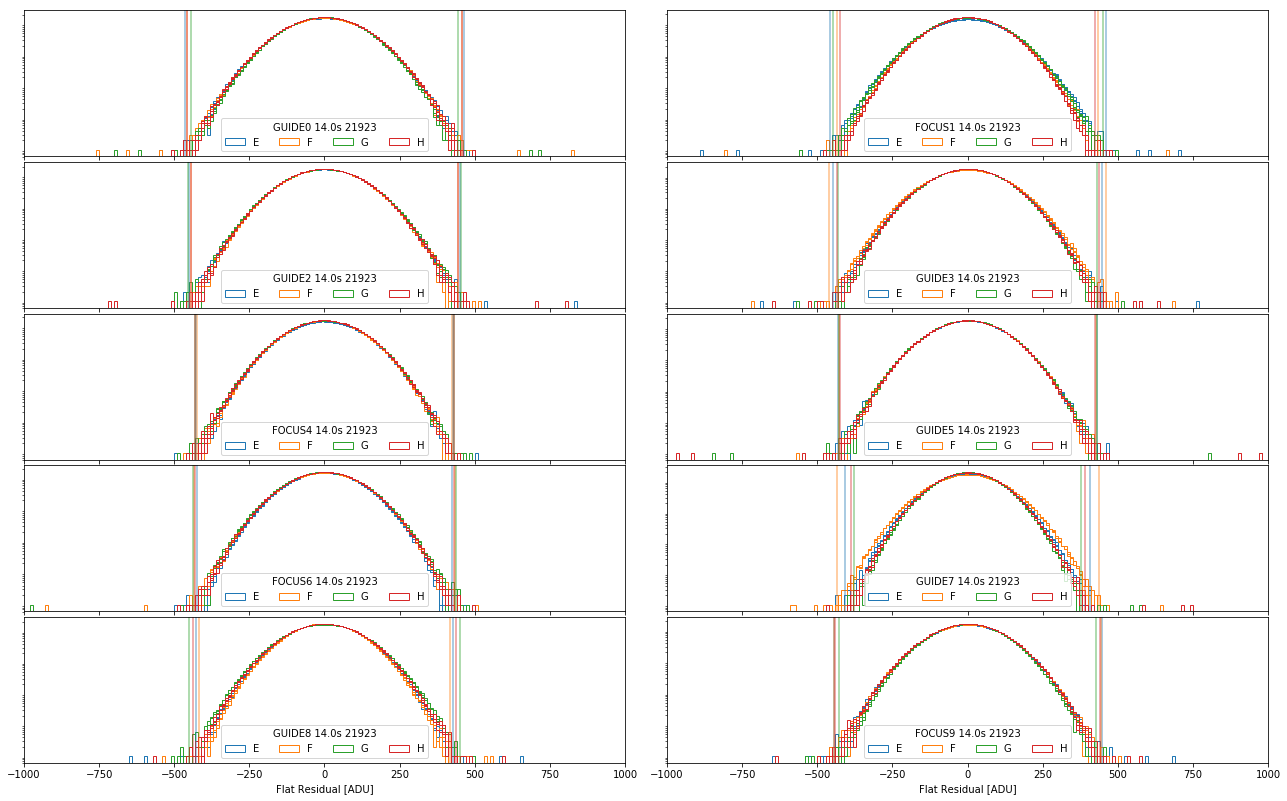

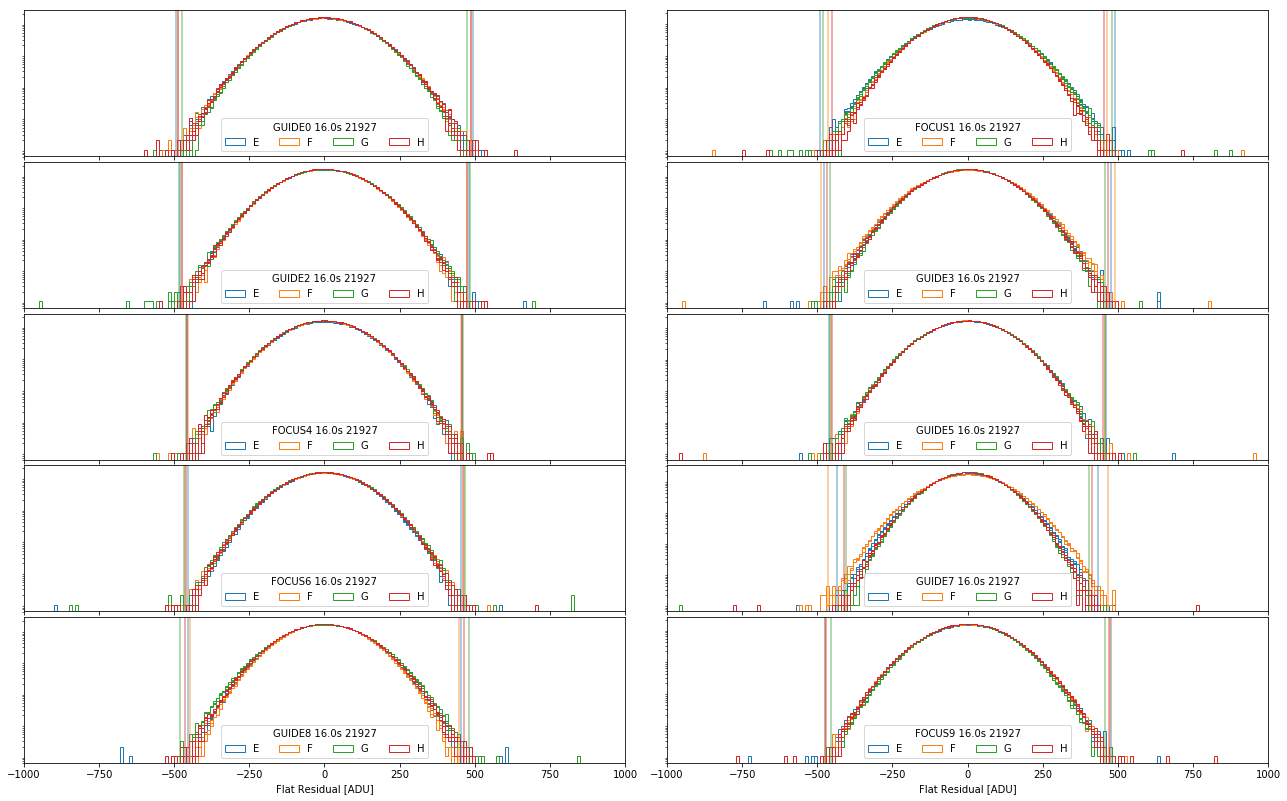

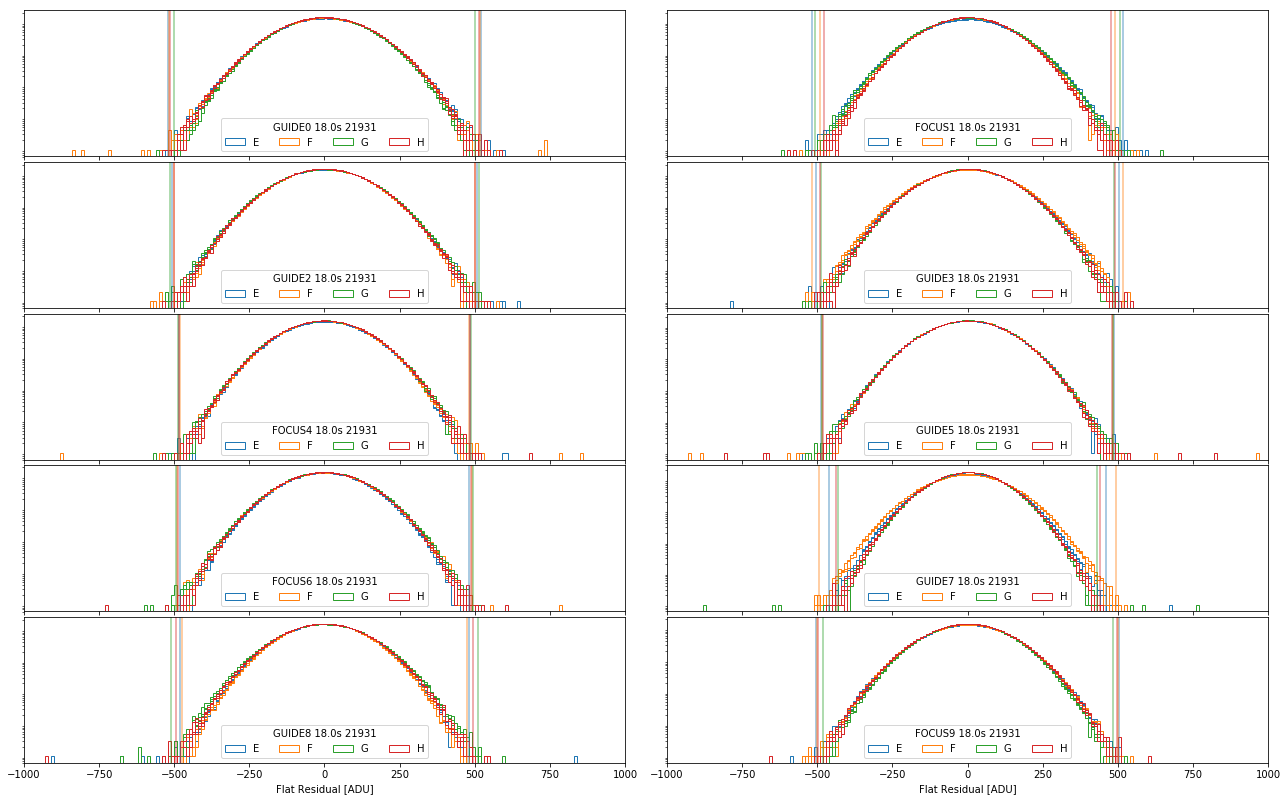

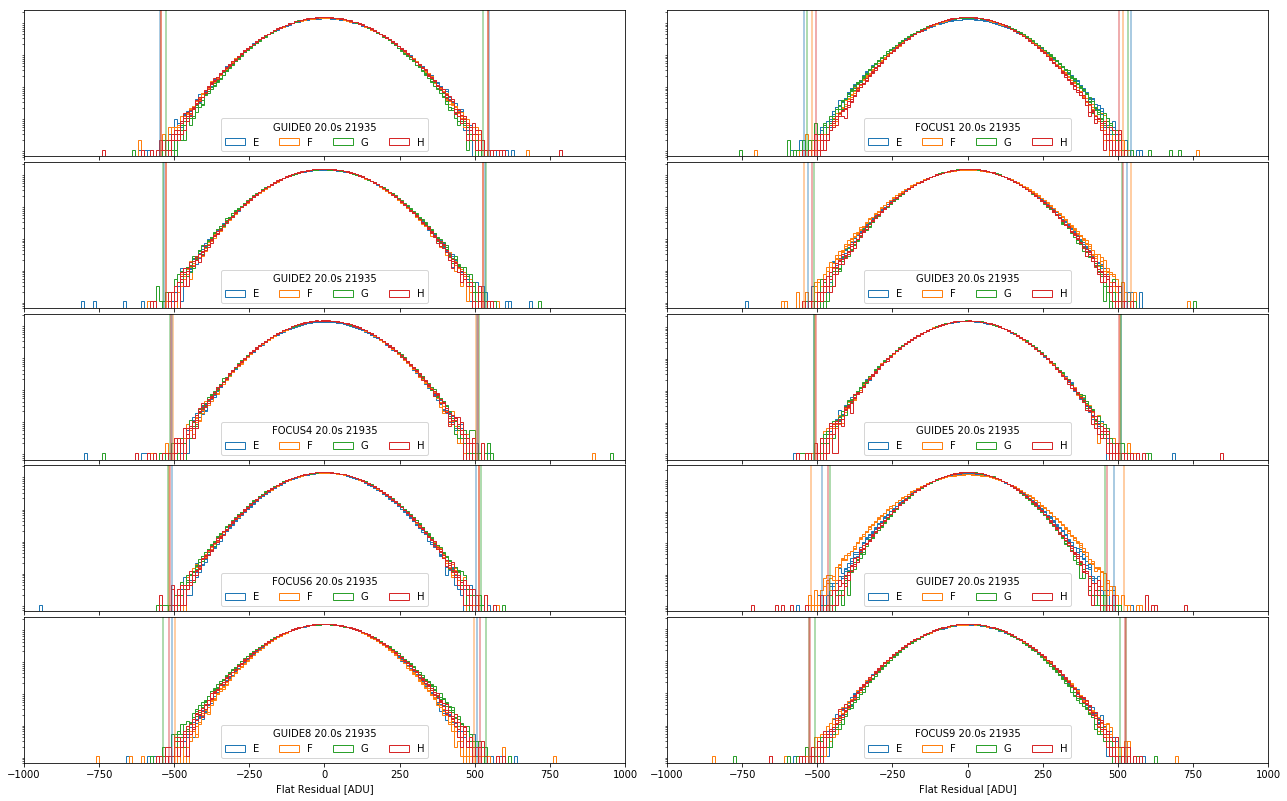

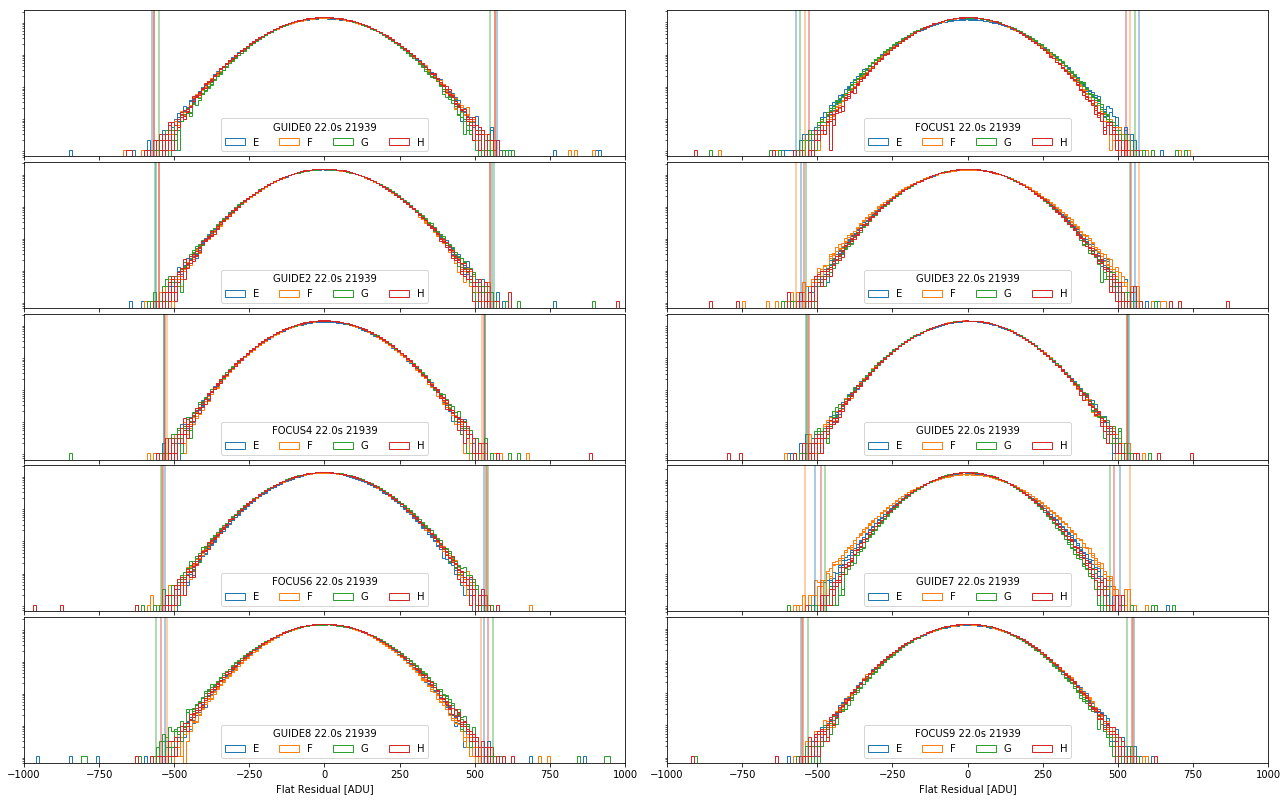

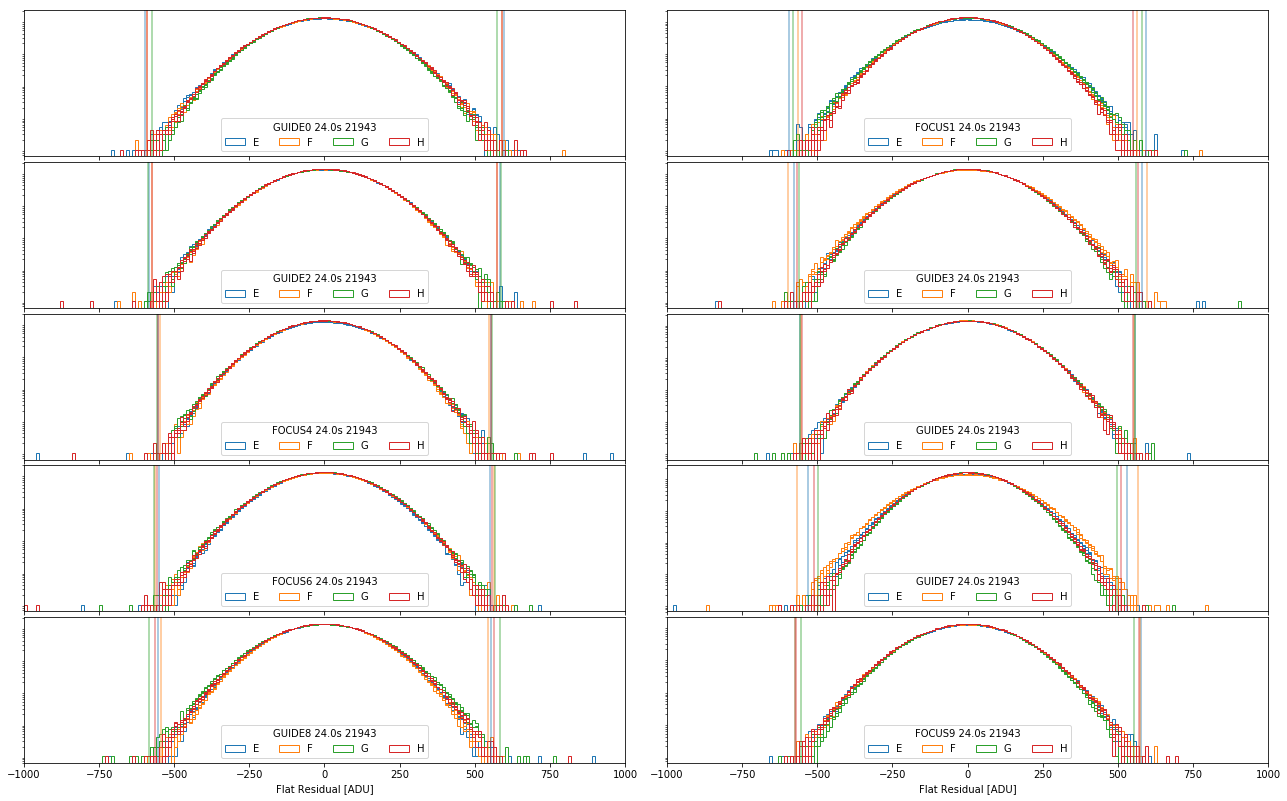

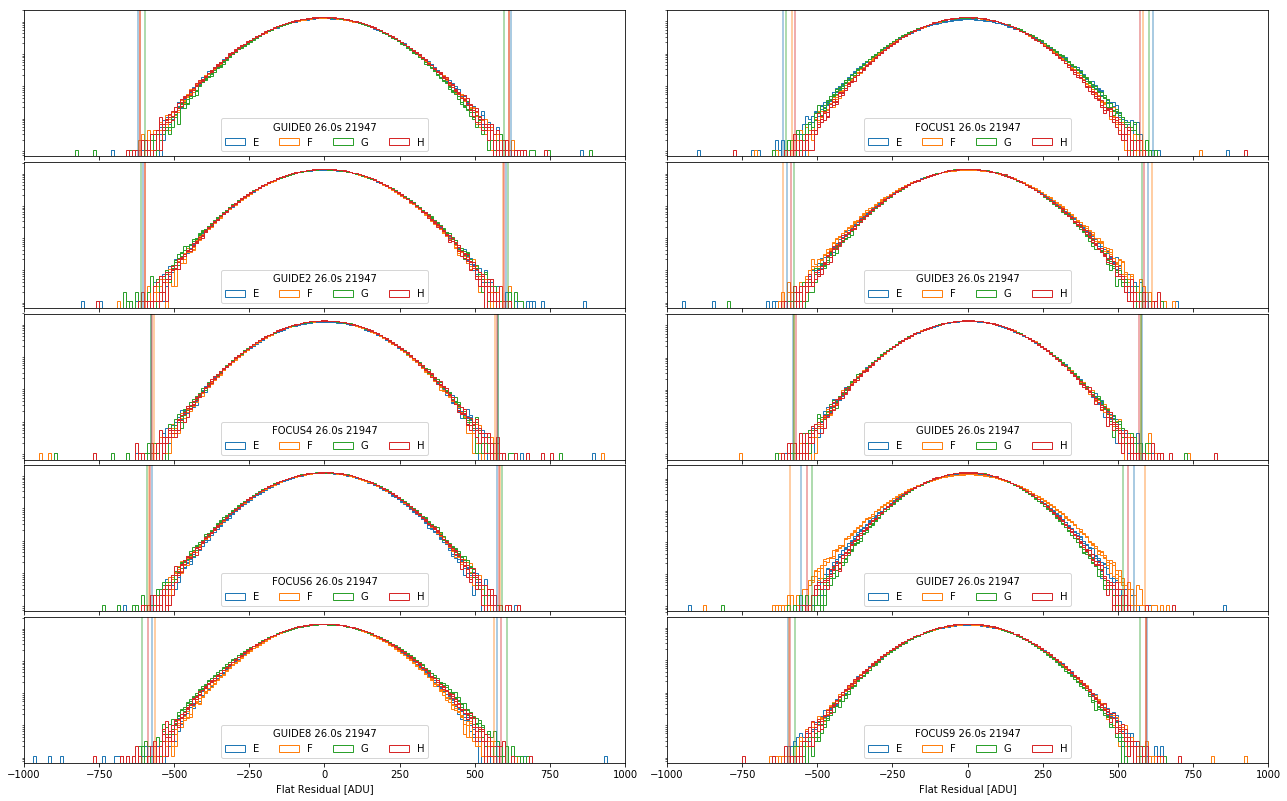

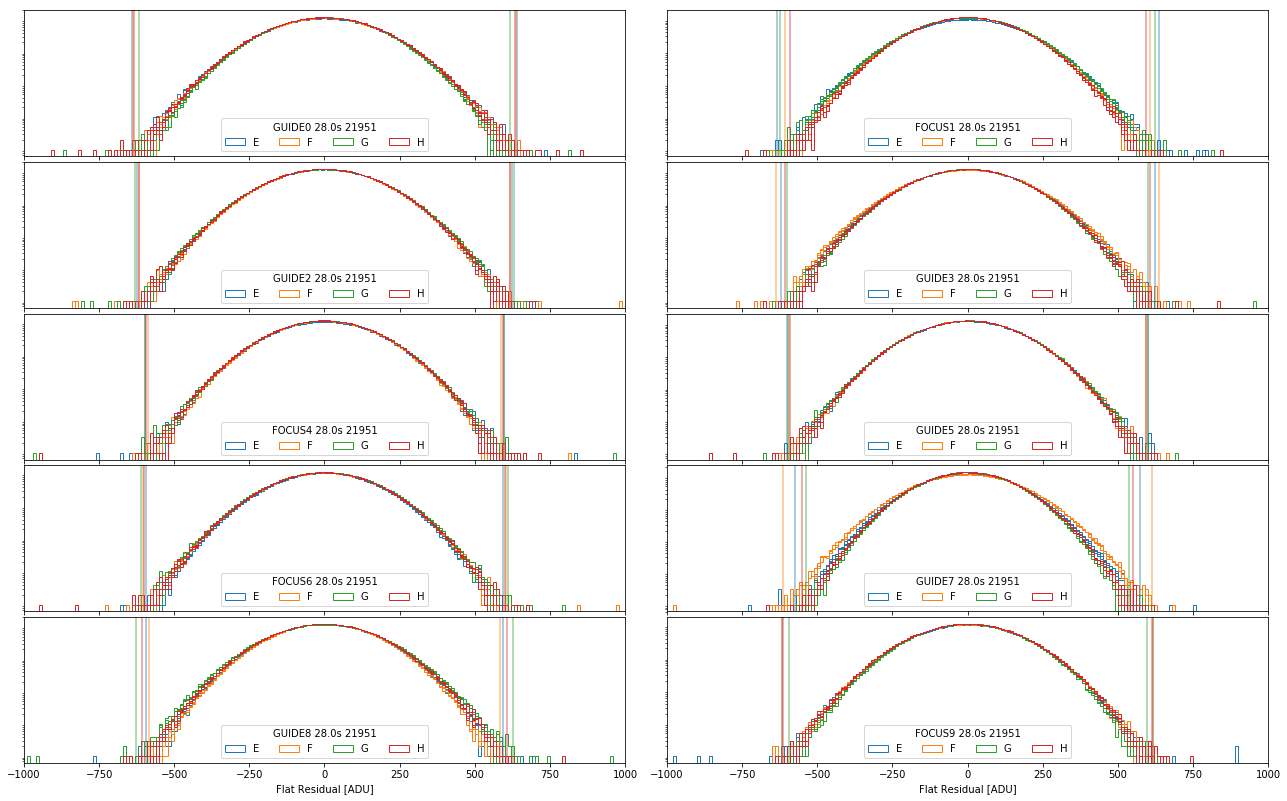

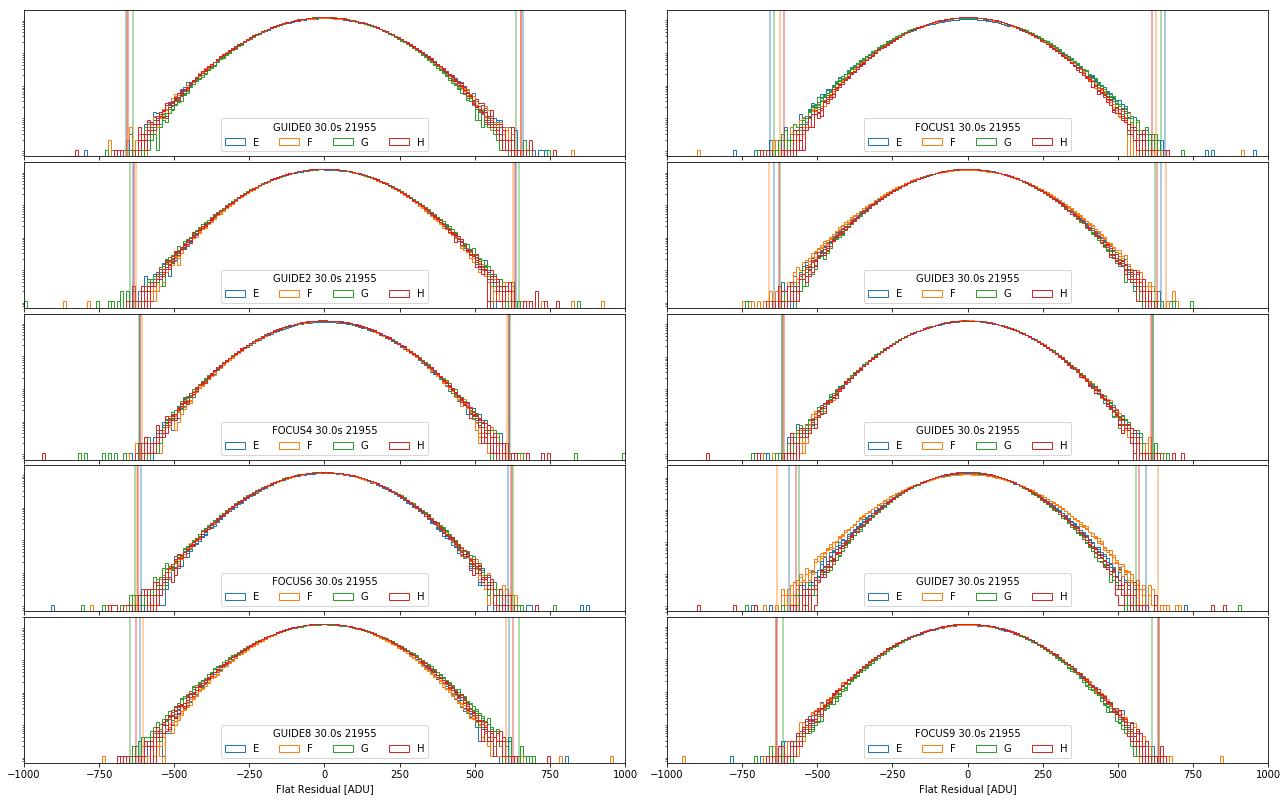

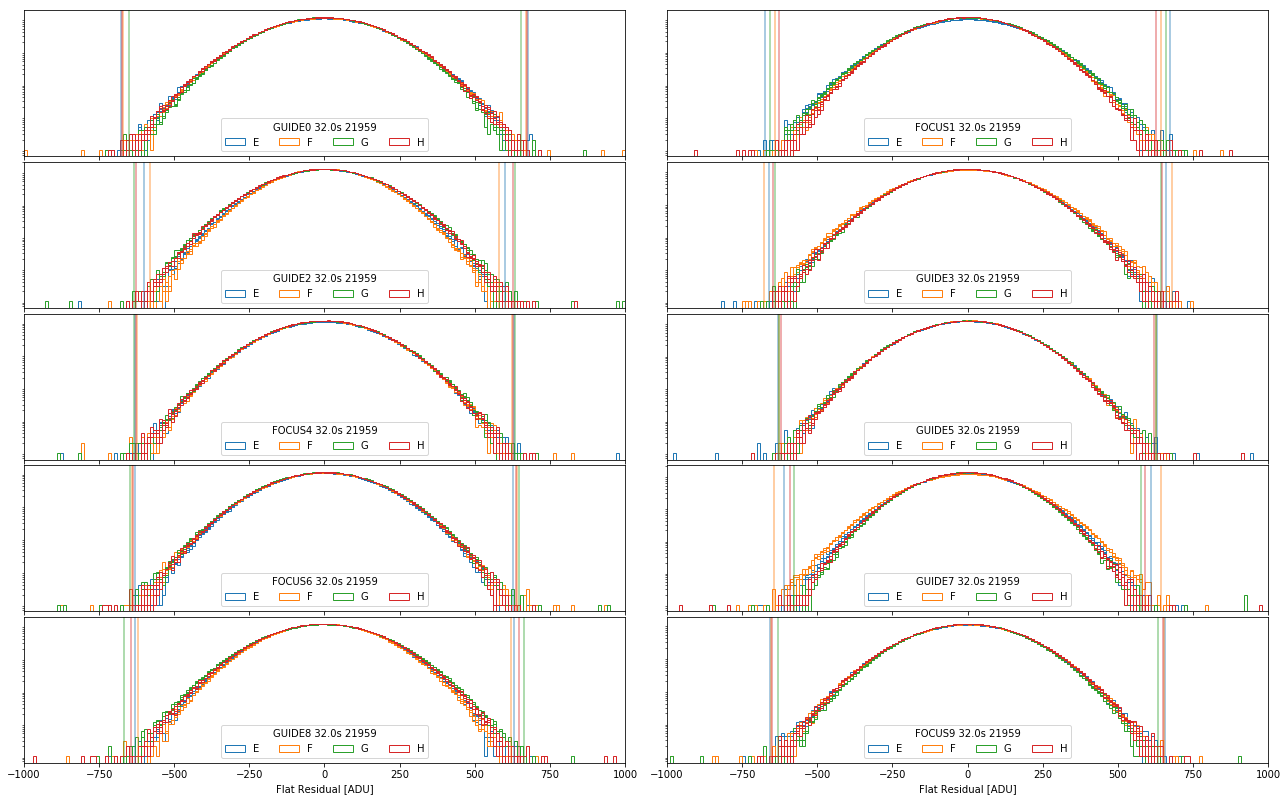

In [19]:
for first in flats:
    texp = flats[first]['texp']
    estimate_variance(first, save=str(plotdir / 'flatvar_20191027_{0}.png'.format(texp)))
    plt.show()

## Fit gains for each amplifier

In [20]:
def fit_gain(xmax=4.2, fitmax=3.5, usebias=False, save=None):
    gain = {}
    nseq = len(flats)
    print('Fitting gains using {0} flat sequences.'.format(nseq))
    nvec = nseq + 1 if usebias else nseq
    xvec = np.empty(nvec)
    yvec = np.empty(nvec)
    xfit = np.array([0, 1e4 * xmax])
    fig, axes = plt.subplots(5, 2, sharex=True, figsize=(18, 11))
    for k, gfa in enumerate(desietcimg.gfa.GFACamera.gfa_names):
        gain[gfa] = {}
        ax = axes[k // 2, k % 2]
        # Extract median pixel values in ADU and corresponding variances in ADU ** 2
        # for each exposure time.
        for j, amp in enumerate(desietcimg.gfa.GFACamera.amp_names):
            for i, (first, flat) in enumerate(flats.items()):
                _, xvec[i], _ = flat['pixstats'][gfa][amp]
                yvec[i], _, _ = flat['varstats'][gfa][amp]
            # Scale variances by factor of 2 since they are differences of noisy values.
            yvec /= 2
            # Use the bias as an additional point at (x,y) = (0, rdnoise ** 2) if requested.
            if usebias:
                xvec[-1] = 0
                yvec[-1] = desietcimg.gfa.GFACamera.calib_data[gfa][amp]['RDNOISE'] ** 2
            # Plot these values.
            c = plt.rcParams['axes.prop_cycle'].by_key()['color'][j]
            yoff = 0.2 * j
            ax.plot(1e-4 * xvec, 1e-4 * yvec + yoff, 'x', c=c)
            ax.set_ylabel('Variance [ADU$^2$/1e4]')
            # Perform a linear fit with no constraint that the intercept matched the read noise.
            # Only use exposure times with x < fitmax to avoid saturation effects.
            fitsel = 1e-4 * xvec < fitmax
            p1, p0 = np.polyfit(xvec[fitsel], yvec[fitsel], deg=1)
            gain[gfa][amp] = 1 / p1
            # Superimpose the fit result.
            yfit = p0 + p1 * xfit
            ax.plot(1e-4 * xfit, 1e-4 * yfit + yoff, '-', c=c, label='{0} {1:.3f}'.format(amp, 1 / p1))
        ax.axvline(fitmax, c='k', ls='--')
        ax.legend(ncol=2, title='{0}'.format(gfa))
        if k in (8, 9):
            ax.set_xlim(0, xmax)
            ax.set_xlabel('Pixel signal [ADU/1e4]')
    plt.subplots_adjust(left=0.03, right=0.99, bottom=0.04, top=0.99, wspace=0.08, hspace=0.04)
    if save:
        plt.savefig(save)
    return gain

Fitting gains using 16 flat sequences.


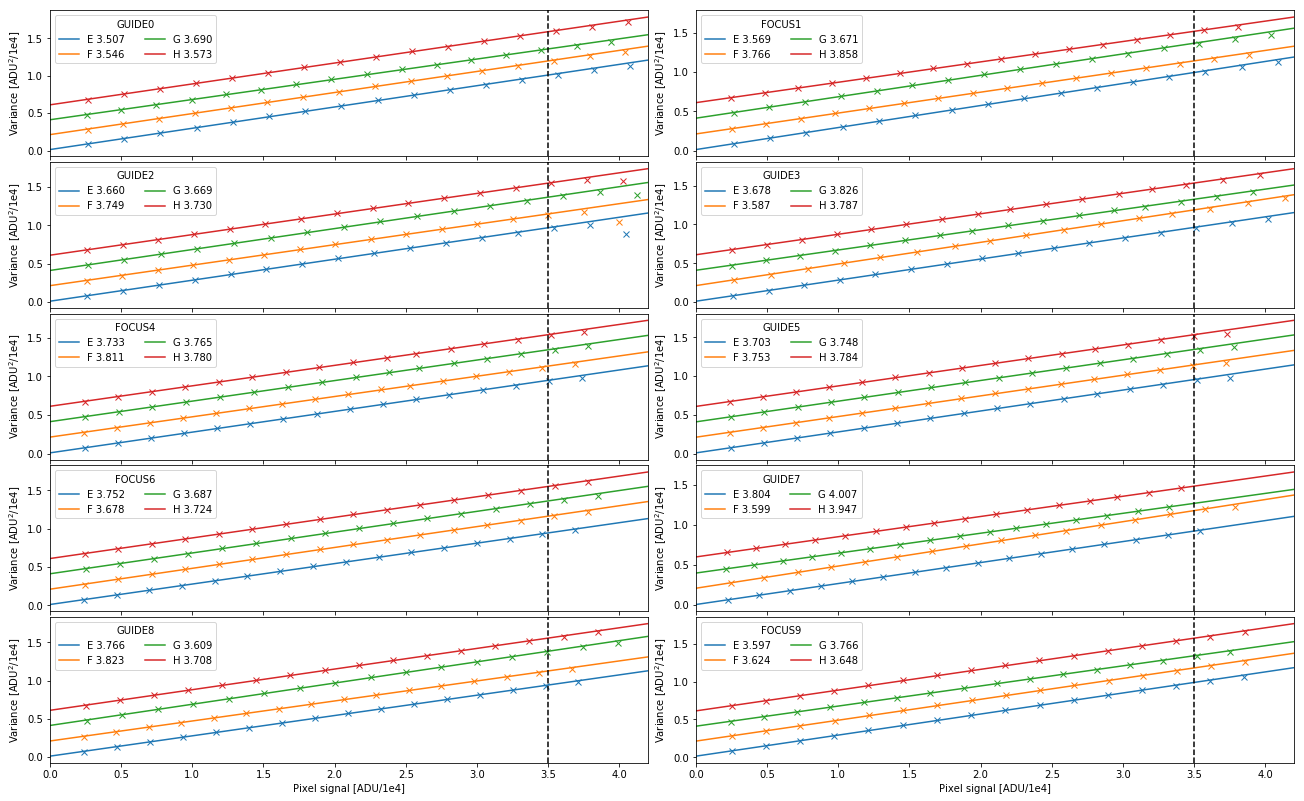

In [22]:
gain = fit_gain(save=str(plotdir / 'flatgain.png'))

In [23]:
repr(gain)

"{'GUIDE0': {'E': 3.506734696585007, 'F': 3.5461189443177954, 'G': 3.6897242251582725, 'H': 3.5729860107104665}, 'FOCUS1': {'E': 3.5694012716901917, 'F': 3.765897411128932, 'G': 3.6708374027095383, 'H': 3.85756531477235}, 'GUIDE2': {'E': 3.660420821717244, 'F': 3.7488084564268482, 'G': 3.6690616323952523, 'H': 3.7304663871667794}, 'GUIDE3': {'E': 3.677850256013969, 'F': 3.5873646994809367, 'G': 3.825539276374339, 'H': 3.787219864877411}, 'FOCUS4': {'E': 3.732665162946023, 'F': 3.811453876707605, 'G': 3.765159694696958, 'H': 3.779670219757742}, 'GUIDE5': {'E': 3.7025889493585846, 'F': 3.7529940828432355, 'G': 3.747699401838478, 'H': 3.7840047233319907}, 'FOCUS6': {'E': 3.752055243848963, 'F': 3.6781762402301976, 'G': 3.687234983625331, 'H': 3.724256852914964}, 'GUIDE7': {'E': 3.8037512729478378, 'F': 3.5985053286654396, 'G': 4.007180120347774, 'H': 3.9465745223723085}, 'GUIDE8': {'E': 3.766462986581315, 'F': 3.8226918956335902, 'G': 3.6088544220025764, 'H': 3.707822908833072}, 'FOCUS9':

## Save Updated Calibrations

In [24]:
desietcimg.gfa.save_calib_data('GFA_calib_flat.fits', gain=gain)

Using default master_zero
Using default master_dark
Using default pixel_mask
Using default readnoise
Using default tempfit
Saved GFA calib data to GFA_calib_flat.fits.


Use this for subsequent dark calibrations:

In [25]:
!cp GFA_calib_flat.fits {CALIB}

## Comparisons

Compare with the gain values from the lab studies and Aaron Meisner's [independent analysis](https://desi.lbl.gov/trac/wiki/Commissioning/Planning/gfachar/gain_20191027):

In [26]:
ameisner_gain = {
    'GUIDE0': { 'E': 3.516, 'F': 3.575, 'G': 3.714, 'H': 3.581},
    'FOCUS1': { 'E': 3.589, 'F': 3.790, 'G': 3.686, 'H': 3.867},
    'GUIDE2': { 'E': 3.686, 'F': 3.763, 'G': 3.716, 'H': 3.788},
    'GUIDE3': { 'E': 3.687, 'F': 3.624, 'G': 3.852, 'H': 3.785},
    'FOCUS4': { 'E': 3.766, 'F': 3.824, 'G': 3.765, 'H': 3.817},
    'GUIDE5': { 'E': 3.715, 'F': 3.792, 'G': 3.761, 'H': 3.779},
    'FOCUS6': { 'E': 3.744, 'F': 3.715, 'G': 3.720, 'H': 3.749},
    'GUIDE7': { 'E': 3.814, 'F': 3.609, 'G': 3.987, 'H': 3.906},
    'GUIDE8': { 'E': 3.792, 'F': 3.855, 'G': 3.610, 'H': 3.728},
    'FOCUS9': { 'E': 3.641, 'F': 3.659, 'G': 3.823, 'H': 3.639},    
}

In [27]:
def compare_gain(label='20191027', save=None):
    # Use the new calibrations written above.
    desietcimg.gfa.GFACamera.calib_data = None
    GFA = desietcimg.gfa.GFACamera(calib_name='GFA_calib_flat.fits')
    markers = '+xo.'
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    for k, gfa in enumerate(GFA.gfa_names):
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][k]
        ax[1].scatter([], [], marker='o', c=color, label=gfa)
        for j, amp in enumerate(GFA.amp_names):
            marker = markers[j]
            labgain = GFA.lab_data[gfa][amp]['GAIN']
            measured = GFA.calib_data[gfa][amp]['GAIN']
            ax[0].scatter(labgain, measured, marker=marker, c=color)
            ax[1].scatter(ameisner_gain[gfa][amp], measured, marker=marker, c=color)
    for j, amp in enumerate(GFA.amp_names):
        ax[1].scatter([], [], marker=markers[j], c='k', label=amp)
    ax[1].legend(ncol=3)
    xlim = np.array([3.48, 4.07])
    for axis in ax:
        axis.set_xlim(*xlim)
        axis.set_ylim(*xlim)
        axis.plot(xlim, xlim, 'k-', zorder=-10, alpha=0.25)
        axis.plot(xlim, 1.01 * xlim, 'k:', zorder=-10, alpha=0.25)
        axis.plot(xlim, 0.99 * xlim, 'k:', zorder=-10, alpha=0.25)
    ax[0].set_xlabel('Lab Data Gain [e/ADU]')
    ax[0].set_ylabel(f'{label} Gain [e/ADU]')
    ax[1].set_xlabel('ameisner Gain [e/ADU]')
    ax[1].set_ylabel(f'{label} Gain [e/ADU]')
    plt.tight_layout()
    if save:
        plt.savefig(save)

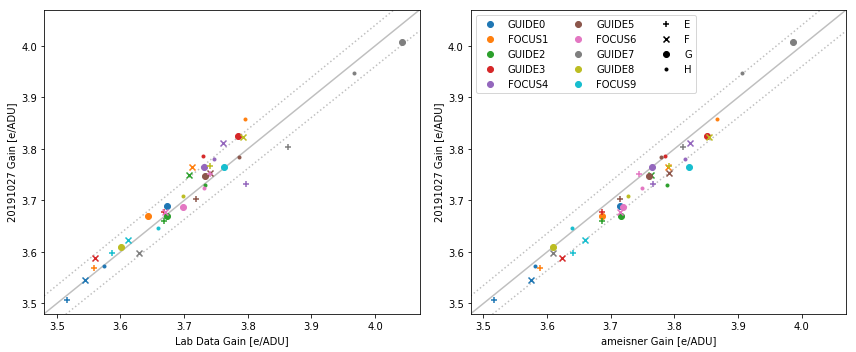

In [28]:
compare_gain(save=str(plotdir / 'gain_compare.png'))